# Definições

    A análise foi realizada sobre uma base de mais de 200 mil pets que adquiriram os planos de saúde em 2023.
    Estão excluídos da análise pets que deixaram o plano por motivos involuntários (óbito ou inadimplentes).
    
# Pontos a considerar

    O tempo de 6 meses é sempre em relação ao último evento do pet com a petlove;
    A probabilidade média de sobrevivência em 6 meses é de 81%.
    

# Principais Destaques
    
   - A etapa de setup (assinatura de contrato e microchipagem) é um fator fundamental do inicio da jornada, a probabilidade de um pet que não passa por essa etapa se manter ativo após 6 meses é de menos de 40% vs. 90% para um pet que fez o setup;
   - Pets filhotes tendem a term uma probabilidade de sobrevivência em 6 meses 8pp pior que um pet adulto/senior (Filhote 76% vs. Adulto/Senior 86%);
   - Os pets com plano completo e essencial possuem probabilidade de sobrevivência em 6 meses de 88-90% vs. 77-78% dos planos leve e tranquilo;
   - Pets com muitos "irmãos" segurados chegam a ter 15pp de sorbevivência a menos comparados a pets sozinhos ou com apenas 1 irmão;
   - Gatos possuem 5pp a menos de sobrevivência comparado aos cachorros
   - Um pet que vacinou ou fez consulta clinica tem cerca de 90% de probabilidade de sobrevivência em 6 meses (~14pp  maior comparado com pets que nunca fizeram esses atendimentos);
   - Compra de adicionais também mostra pets com ~10pp de sobrevivência comparado aos que não compraram;
   - O fato da pessoa ter experiência no ecom não discrimina de forma significativa as curvas de sobrevivência;
   - Mas quem se tornou cliente do Clube mostrou uma curva 6pp melhor que os demais clientes
   
# Próximos passos:
   - Apresentar os novos resultados no workshop de experiência do produto digital de saúde;
   - Já temos um algoritmo de previsão de sobrevivência que acerta com 87% de acurácia, mas com um baixo recall para a categoria de interesse (churn). Podemos priorizar um corte de probabilidade mais alto, como considerar churn quem tem probabilidade abaixo da média geral (81%) e com isso melhorar o recall para 84% em detrimento de impactarmos com ações de retenção clientes que não pensam em deixar de fato o plano (o que estaria ok caso o disparo por CRM não tiver um custo alto);
     
   - Esse algoritmo vai nos permitir criar um modelo de NBA para engajamento, indicando com quem, quando e como devemos comunicar as ações de retenção;
   - Para isso, vamos fazer um brainstorming com time de CRM para pensar nas jornadas e mensagens que queremos usar em cada recomendação do modelo de NBA;
   - Após a segunda rodada de validação do modelo v1, vamos produtizar um escoragem da base de pets para ter diariamente o quem/quando/como comunicar, levaremos isso para Braze para ativar essas réguas em um experimento para validar o efeito do NBA no engajamento e retenção de clientes.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

from tqdm import tqdm

import pydata_google_auth
from google.cloud import bigquery

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, cumulative_dynamic_auc
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Importação dos dados para análise

In [2]:
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
) 

In [3]:
project_id = 'petlove-dataeng-prod-01'

client = bigquery.Client(project=project_id)

In [4]:
sql = f"""
with
  assinatura_contrato as (
      select
        concat('nf-',usp.id) as id
        , parse_date('%d/%m/%Y', substr(usp.digital_signature, 23, 10)) as data_assinatura_contrato
        , b.dt_microchipagem
      from `petlove-dataeng-prod-01.curated_health.health_user_pet` usp
      left join `petlove-dataeng-prod-01.op_health.beneficiarios` b
        on concat('nf-',usp.id) = b.id_pet_bu
      where 1=1
        and digital_signature is not null
        and usp.refdate <= current_date()
        and substr(usp.digital_signature, 23, 10) <> ''
        and b.dt_microchipagem is not null
    )
, setup as (
    select
      id as id_pet_bu
      , data_assinatura_contrato
      , dt_microchipagem
      , case
          when data_assinatura_contrato > dt_microchipagem then data_assinatura_contrato
          when dt_microchipagem >= data_assinatura_contrato then dt_microchipagem
          else dt_microchipagem
        end as data_setup
    from assinatura_contrato
)
  , vacina as (
    select distinct
      id_pet_bu
      , max(data_origem_date) as data_vacina
    from `petlove-dataeng-prod-01.op_health.custos_medicos`
    where 1=1
      and status = 'Ativo'
      and sistema_origem_custo = 'ERP Nofaro'
      and upper(nome_procedimento) like '%VACINA%'
      and upper(nome_procedimento) not like '%CONSULTA%'
    group by 1
  ),
  compra_add as (
    select
      id_pet_bu
      , max(dt_pagamento) as data_pagamento
    from `petlove-dataeng-prod-01.op_health.faturamento_pet_nofaro`
    where 1=1
      and vlr_carencia <> 0
    group by 1
  ),
  clinico_geral as (
    select
      id_pet_bu
      , max(data_origem_date) as data_atend_clin_geral
    from `petlove-dataeng-prod-01.op_health.custos_medicos`
    where 1=1
      and status = 'Ativo'
      and sistema_origem_custo = 'ERP Nofaro'
      and (upper(nome_procedimento) like '%CONSULTA%' and upper(nome_procedimento) like '%GERAL%' and upper(nome_procedimento) not like '%VACINA%')
    group by id_pet_bu
  ),
  pedido_ecom as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when max(fpf1.chv_data_emissao_nota_fiscal) > max(fpf2.chv_data_emissao_nota_fiscal) then max(fpf1.chv_data_emissao_nota_fiscal)
          when max(fpf1.chv_data_emissao_nota_fiscal) < max(fpf2.chv_data_emissao_nota_fiscal) then max(fpf2.chv_data_emissao_nota_fiscal)
          when max(fpf1.chv_data_emissao_nota_fiscal) = max(fpf2.chv_data_emissao_nota_fiscal) then max(fpf1.chv_data_emissao_nota_fiscal)
      end as dt_pedido_ecom
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf1
      on dc1.chv_cliente = fpf1.chv_cliente
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf2
      on dc2.chv_cliente = fpf2.chv_cliente
    group by 1,2
  ),
  primeiro_pedido_ecom as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when min(fpf1.chv_data_emissao_nota_fiscal) < min(fpf2.chv_data_emissao_nota_fiscal) then date(min(fpf1.chv_data_emissao_nota_fiscal))
          when min(fpf1.chv_data_emissao_nota_fiscal) > min(fpf2.chv_data_emissao_nota_fiscal) then date(min(fpf2.chv_data_emissao_nota_fiscal))
          when min(fpf1.chv_data_emissao_nota_fiscal) = min(fpf2.chv_data_emissao_nota_fiscal) then date(min(fpf1.chv_data_emissao_nota_fiscal))
          when min(fpf1.chv_data_emissao_nota_fiscal) is null then date(min(fpf2.chv_data_emissao_nota_fiscal))
          when min(fpf2.chv_data_emissao_nota_fiscal) is null then date(min(fpf1.chv_data_emissao_nota_fiscal))
      end as dt_primeiro_pedido_ecom
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente`  dc2
      on dc2.email_aberto = lower(trim(b.email))
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf1
      on dc1.chv_cliente = fpf1.chv_cliente
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf2
      on dc2.chv_cliente = fpf2.chv_cliente
    group by 1,2
  ),
  primeiro_servico_dh as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when min(dc1.dt_primeiro_servico) < min(dc2.dt_primeiro_servico) then date(min(dc1.dt_primeiro_servico))
          when min(dc1.dt_primeiro_servico) > min(dc2.dt_primeiro_servico) then date(min(dc2.dt_primeiro_servico))
          when min(dc1.dt_primeiro_servico) = min(dc2.dt_primeiro_servico) then date(min(dc1.dt_primeiro_servico))
          when min(dc1.dt_primeiro_servico) is null then date(min(dc2.dt_primeiro_servico))
          when min(dc2.dt_primeiro_servico) is null then date(min(dc1.dt_primeiro_servico))
      end as dt_primeiro_servico_dh
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
    group by 1,2  
  ),
  cluster_tutores as (
    select
      id_tutor
      , cluster_name
      , rank() over(partition by id_tutor order by refdate desc) as rk
    from `op_health.tutores_clusters`
    order by 2 asc
  ),
  clube as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when min(dc1.dt_entrada_clube) < min(dc2.dt_entrada_clube) then date(min(dc1.dt_entrada_clube))
          when min(dc1.dt_entrada_clube) > min(dc2.dt_entrada_clube) then date(min(dc2.dt_entrada_clube))
          when min(dc1.dt_entrada_clube) = min(dc2.dt_entrada_clube) then date(min(dc1.dt_entrada_clube))
          when min(dc1.dt_entrada_clube) is null then date(min(dc2.dt_entrada_clube))
          when min(dc2.dt_entrada_clube) is null then date(min(dc1.dt_entrada_clube))
      end as dt_entrada_clube
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
    group by 1,2    
  ),
  ecom_detalhado as (
    with uniao_chaves as (
      select
        b.id_pet_bu
        , b.nome_pet
        , mc1.setor
        , mc1.familia
        , mc1.subfamilia
        , mc1.marca
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
        on dc1.cpf_aberto = b.documento
      left join `petlove-dataeng-prod-01.dw_corporativo.dts_margem_conciliacao` mc1
        on dc1.chv_cliente = mc1.chv_cliente
      where 1=1
        and mc1.setor in ('Alimentos','Medicina e Bem Estar','Brinquedos','Acessórios','Higiene e Beleza')
      union all
      select
        b.id_pet_bu
        , b.nome_pet
        , mc2.setor
        , mc2.familia
        , mc2.subfamilia
        , mc2.marca
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
      left join `petlove-dataeng-prod-01.dw_corporativo.dts_margem_conciliacao` mc2
        on dc2.chv_cliente = mc2.chv_cliente
      where 1=1
        and mc2.setor in ('Alimentos','Medicina e Bem Estar','Brinquedos','Acessórios','Higiene e Beleza')
    )
    select
      id_pet_bu
      , nome_pet
      , string_agg(distinct setor, " | " order by setor asc) as mix_setores
      , string_agg(distinct familia, " | " order by familia asc) as mix_familias
      , string_agg(distinct subfamilia, " | " order by subfamilia asc) as mix_subfamilias
      , string_agg(distinct marca, " | " order by marca asc) as mix_marcas
    from uniao_chaves
    group by 1,2
  ),
  frequencia_compra as (
    with uniao_chaves as (
      select
        b.id_pet_bu
        , b.nome_pet
        , fpf1.chv_data_emissao_nota_fiscal as primeiro_pedido
        , fpf1.chv_data_emissao_nota_fiscal as ultimo_pedido
        , fpf1.pedido_beagle
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
        on dc1.cpf_aberto = b.documento
      left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf1
        on dc1.chv_cliente = fpf1.chv_cliente
      union all
      select
        b.id_pet_bu
        , b.nome_pet
        , fpf2.chv_data_emissao_nota_fiscal as primeiro_pedido
        , fpf2.chv_data_emissao_nota_fiscal as ultimo_pedido
        , fpf2.pedido_beagle
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
      left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf2
        on dc2.chv_cliente = fpf2.chv_cliente
    )
    select
      id_pet_bu
      , nome_pet
      , min(primeiro_pedido) primeiro_pedido
      , max(ultimo_pedido) ultimo_pedido
      , count(distinct pedido_beagle) as pedidos
      , date_diff(max(ultimo_pedido),min(primeiro_pedido), day) as dias
      , case
          when count(distinct pedido_beagle) = 0 then 0
          else round(date_diff(max(ultimo_pedido),min(primeiro_pedido), day)/count(distinct pedido_beagle),0)
      end as frequencia
    from uniao_chaves
    -- where id_pet_bu = 'nf-181328'
    group by 1,2  
  ),
  beneficiarios as (
    select
      id_tutor,
      (case when REGEXP_EXTRACT(lower(email), r'@(.+)') in ('gmail.com', 'hotmail.com', 'yahoo.com.br','outlook.com', 'icloud.com', 'uol.com.br', 'live.com', 'terra.com.br', 'yahoo.com') then REGEXP_EXTRACT(lower(email), r'@(.+)')
            else 'outros.com'
            end) as email_dominio,
      idade_pet_venda,
      idade_pet_anos,
      cast(id_pet as int64) as id_pet,
      nome_pet,
      dt_inclusao_pet,
      date_diff( coalesce(dt_desligamento, current_date),dt_inclusao_pet, day) as tempo_ativo,
      fl_ativo,
      especie,
      status_microchip,
      coalesce(dt_desligamento, current_date) as dt_desligamento_nn,
      case
        when lower(nome_plano_dts_pet) like '%leve%' then 'leve'
        when lower(nome_plano_dts_pet) like '%tranquilo%' then 'tranquilo'
        when lower(nome_plano_dts_pet) like '%ideal%' then 'ideal'
        when lower(nome_plano_dts_pet) like '%completo%' then 'completo'
        when lower(nome_plano_dts_pet) like '%essencial%' then 'essencial'
        else 'outros' 
      end as plano,
      fl_inside_sales
    from `op_health.beneficiarios`
    where 1=1
      and fl_contrato_migrado=0
      and fl_pet_sem_inclusao=0
      and fl_colaborador=0
      and dt_inclusao_pet>='2023-01-01' and dt_inclusao_pet<='2023-12-31' 
      and idade_pet_venda is not null 
      and idade_pet_venda>=0
      AND empresa = 'Nofaro'
      AND especie is not null
      AND (motivo_desligamento not in ('Óbito', 'defaulting_wating', 'defaulting_failed', 'death', 'defaulting', 'Morte de pet', 'Inadimplência', 'Inadimplência: aguardando', 'Inadimplência: falha no p')
      or motivo_desligamento is null)
  )
, simultaneos as (
    select
      b1.id_tutor,
      b1.id_pet,
      count(distinct b2.id_pet) as pets_simultaneos_ativos
    from beneficiarios b1
    left join beneficiarios b2
      on b1.id_tutor = b2.id_tutor
      and ((b1.dt_desligamento_nn > b2.dt_inclusao_pet and b1.dt_desligamento_nn <= b2.dt_desligamento_nn)
      or (b1.dt_inclusao_pet > b2.dt_inclusao_pet and b1.dt_inclusao_pet <= b2.dt_desligamento_nn))
    group by 1, 2
  )
  ,juncao as (
  select
    b.id_tutor,
    b.email_dominio,
    b.idade_pet_venda,
    b.idade_pet_anos,
    b.id_pet,
    b.nome_pet,
    b.dt_inclusao_pet,
    (case when b.tempo_ativo<0 then 0 else b.tempo_ativo end) as tempo_ativo,
    cast(b.fl_ativo as bool) as fl_ativo,
    b.plano,
    b.especie,
    b.status_microchip,
    b.fl_inside_sales,
    s.pets_simultaneos_ativos,
    st.data_setup as dt_setup,
    (case when st.id_pet_bu is null then false else true end) as tem_setup,
    v.data_vacina as dt_max_vacina,
    (case when v.id_pet_bu is null then false else true end) as tem_vacina,
    ca.data_pagamento as dt_max_compra_add,
    (case when ca.id_pet_bu is null then false else true end) as tem_adicional,
    cg.data_atend_clin_geral as dt_max_clin_geral,
    (case when cg.id_pet_bu is null then false else true end) as tem_atendimento,
    pe.dt_pedido_ecom as dt_max_pedido_ecom,
    (case when pe.id_pet_bu is null then false else true end) as tem_ecom,
    ppe.dt_primeiro_pedido_ecom as dt_primeiro_pedido_ecom,
    psdh.dt_primeiro_servico_dh as dt_primeiro_servico_dh,
    c.dt_entrada_clube,
    ct.cluster_name,
    case
      when ppe.dt_primeiro_pedido_ecom < b.dt_inclusao_pet then 'cliente ecom antes do plano'
      when b.dt_inclusao_pet < ppe.dt_primeiro_pedido_ecom then 'cliente ecom depois do plano'
      when ppe.dt_primeiro_pedido_ecom is null then 'não é cliente ecom'
      when ppe.dt_primeiro_pedido_ecom = b.dt_inclusao_pet then 'adesão de plano e ecom na mesma data'
      else 'verificar'
    end as fl_cross_ecom,
    case
      when psdh.dt_primeiro_servico_dh < b.dt_inclusao_pet then 'cliente dh antes do plano'
      when b.dt_inclusao_pet < psdh.dt_primeiro_servico_dh then 'cliente dh depois do plano'
      when psdh.dt_primeiro_servico_dh is null then 'não é cliente dh'
      when psdh.dt_primeiro_servico_dh = b.dt_inclusao_pet then 'adesão de plano e dh na mesma data'
      else 'verificar'
    end as fl_cross_dh,
    case
      when c.dt_entrada_clube is not null then 1
      else 0
    end as fl_clube,
    ed.mix_setores,
    ed.mix_familias,
    ed.mix_subfamilias,
    ed.mix_marcas,
    fc.frequencia as frequencia_compra_ecom
  from beneficiarios b
  join simultaneos s
    on b.id_tutor = s.id_tutor 
    and b.id_pet = s.id_pet
    and s.pets_simultaneos_ativos>0
  left join setup st
    on concat('nf-',b.id_pet) = st.id_pet_bu
  left join vacina v
    on concat('nf-',b.id_pet) = v.id_pet_bu
  left join compra_add ca
    on concat('nf-',b.id_pet) = ca.id_pet_bu
  left join clinico_geral cg
    on concat('nf-',b.id_pet) = cg.id_pet_bu
  left join pedido_ecom pe
    on concat('nf-',b.id_pet) = pe.id_pet_bu
    and pe.dt_pedido_ecom is not null
  left join primeiro_pedido_ecom ppe
    on concat('nf-',b.id_pet) = ppe.id_pet_bu
    and ppe.dt_primeiro_pedido_ecom is not null
  left join cluster_tutores ct
    on b.id_tutor = ct.id_tutor
    and ct.rk = 1
  left join primeiro_servico_dh psdh
    on concat('nf-',b.id_pet) = psdh.id_pet_bu
    and psdh.dt_primeiro_servico_dh is not null
  left join clube c
    on concat('nf-',b.id_pet) = c.id_pet_bu
    and c.dt_entrada_clube is not null
  left join ecom_detalhado ed
    on concat('nf-',b.id_pet) = ed.id_pet_bu
  left join frequencia_compra fc
    on concat('nf-',b.id_pet) = fc.id_pet_bu
where b.plano not in ('outros')
  )
  , base_final as (
    select * 
    from juncao
    unpivot(data for habito in (dt_inclusao_pet as 'inclusao', dt_setup as 'setup', dt_max_vacina as 'vacina', dt_max_compra_add as 'add', dt_max_clin_geral as 'clinico', dt_max_pedido_ecom as 'ecom'))
  )
select
  f.id_tutor
  , f.email_dominio
  , f.idade_pet_venda
  , f.idade_pet_anos
  , f.id_pet
  , b.dt_inclusao_pet
  , coalesce(b.dt_desligamento, current_date()) as dt_desligamento
  , f.nome_pet
  , f.tempo_ativo
  , f.plano
  , f.especie
  , initcap(trim(b.cidade_tutor)) cidade
  , initcap(trim(b.tutor_bairro)) bairro
  , f.status_microchip
  , cast(f.pets_simultaneos_ativos as float64) as pets_simultaneos_ativos
  , max(f.tem_setup) setup
  , max(f.tem_vacina) vacina
  , max(f.tem_adicional) add
  , max(f.tem_atendimento) clinico
  , max(f.tem_ecom) ecom
  , string_agg(f.habito order by data) as mix_procedimentos_data
  , string_agg(f.habito order by f.habito) as mix_procedimentos_alf
  , split(string_agg(f.habito order by data desc), ',')[offset(0)] ultimo_evento
  , max(f.data) as data_ultimo_evento
  , f.dt_primeiro_pedido_ecom
  , f.dt_primeiro_servico_dh
  , f.dt_entrada_clube
  , f.mix_setores
  , f.mix_familias
  , f.mix_subfamilias
  , f.mix_marcas
  , f.frequencia_compra_ecom
  , f.cluster_name
  , case
      when f.fl_ativo = true then false
      when f.fl_ativo = false then true
  end as fl_churn
  , f.fl_inside_sales
  , f.fl_clube
  , f.fl_cross_ecom
  , f.fl_cross_dh
  , case when date_diff(coalesce(b.dt_desligamento, current_date()),max(f.data), day)<0 then 0
      else date_diff(coalesce(b.dt_desligamento, current_date()),max(f.data), day) end as survival_in_days
from base_final f
left join `petlove-dataeng-prod-01.op_health.beneficiarios` b
  on concat('nf-',f.id_pet) = b.id_pet_bu
group by
  f.id_tutor
  , f.email_dominio
  , f.idade_pet_venda
  , f.idade_pet_anos
  , f.id_pet
  , b.dt_inclusao_pet
  , b.dt_desligamento
  , f.nome_pet
  , f.tempo_ativo
  , f.plano
  , f.especie
  , b.cidade_tutor
  , b.tutor_bairro
  , f.status_microchip
  , f.pets_simultaneos_ativos
  , f.dt_primeiro_pedido_ecom
  , f.dt_primeiro_servico_dh
  , f.dt_entrada_clube
  , f.mix_setores
  , f.mix_familias
  , f.mix_subfamilias
  , f.mix_marcas
  , f.frequencia_compra_ecom
  , f.cluster_name
  , f.fl_ativo
  , f.fl_inside_sales
  , f.fl_cross_ecom
  , f.fl_clube
  , f.fl_cross_dh
"""

df = client.query(sql).to_dataframe()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200911 entries, 0 to 200910
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id_tutor                 200911 non-null  object 
 1   email_dominio            200911 non-null  object 
 2   idade_pet_venda          200911 non-null  float64
 3   idade_pet_anos           200911 non-null  float64
 4   id_pet                   200911 non-null  Int64  
 5   dt_inclusao_pet          200911 non-null  dbdate 
 6   dt_desligamento          200911 non-null  dbdate 
 7   nome_pet                 200911 non-null  object 
 8   tempo_ativo              200911 non-null  Int64  
 9   plano                    200911 non-null  object 
 10  especie                  200911 non-null  object 
 11  cidade                   200726 non-null  object 
 12  bairro                   200910 non-null  object 
 13  status_microchip         200911 non-null  object 
 14  pets

In [6]:
df.set_index('id_pet', inplace=True)

In [7]:
conditions = [
    (df['idade_pet_anos']<= 1),
    (df['idade_pet_anos']>1) & (df['idade_pet_anos']<=2),
    (df['idade_pet_anos']>2) & (df['idade_pet_anos']<=4),
    (df['idade_pet_anos']>4) & (df['idade_pet_anos']<=6),
    (df['idade_pet_anos']>6) & (df['idade_pet_anos']<=8),
    (df['idade_pet_anos']>8) & (df['idade_pet_anos']<=10),
    (df['idade_pet_anos']>10) & (df['idade_pet_anos']<=12),
    (df['idade_pet_anos']>12) & (df['idade_pet_anos']<=14),
    (df['idade_pet_anos']>14) & (df['idade_pet_anos']<=16),
    (df['idade_pet_anos']>16)
]

choices = [
    '0: De 0 a 1 ano',
    '1: De 1 a 2 anos',
    '2: De 2 a 4 anos',
    '3: De 4 a 6 anos',
    '4: De 6 a 8 anos',
    '5: De 8 a 10 anos',
    '6: De 10 a 12 anos',
    '7: De 12 a 14 anos',
    '8: De 14 a 16 anos',
    '9: 16 anos ou +',
]

df['faixa_idade'] = np.select(conditions, choices, np.nan)

In [8]:
conditions = [
    (df['idade_pet_anos']<=2),
    (df['idade_pet_anos']>2) & (df['idade_pet_anos']<=10),
    (df['idade_pet_anos']>10)
]

choices = [
    '0: Filhote',
    '1: Adulto',
    '2: Senior'
]

df['idade_pet'] = np.select(conditions, choices, np.nan)

In [9]:
conditions = [
    (df['pets_simultaneos_ativos']<= 1),
    (df['pets_simultaneos_ativos']>1) & (df['pets_simultaneos_ativos']<=2),
    (df['pets_simultaneos_ativos']>2) & (df['pets_simultaneos_ativos']<=4),
    (df['pets_simultaneos_ativos']>4) & (df['pets_simultaneos_ativos']<=9),
    (df['pets_simultaneos_ativos']>9)
]

choices = [
    '0: 1 pet',
    '1: 2 pets',
    '2: 3 a 4 pets',
    '3: 5 a 9 pets',
    '4: 10+ pets',
]

df['faixa_pets_simultaneos_ativos'] = np.select(conditions, choices, "Outros")

In [10]:
col = 'frequencia_compra_ecom'

conditions = [
    (df[col] <= 15),
    (df[col]>15) & (df[col]<=30),
    (df[col]>30) & (df[col]<=60),
    (df[col]>60) & (df[col]<=90),
    (df[col]>90) & (df[col]<=180),
    (df[col]>180) & (df[col]<=365),
    (df[col]>365)
]

choices = [
    '0 - Menor 15 Dias',
    '1 - 15 a 30 Dias',
    '2 - 30 a 60 Dias',
    '3 - 60 a 90 Dias',
    '4 - 90 a 180 Dias',
    '5 - 180 a 365 Dias',
    '6 - Mais de 365 Dias'
]

df['faixa_frequencia_compra_ecom'] = np.select(conditions, choices, '7. - Sem Compra')

In [11]:
df['plano'] = df['plano'].astype('category')
df['faixa_idade'] = df['faixa_idade'].astype('category')
df['idade_pet'] = df['idade_pet'].astype('category')
df['faixa_pets_simultaneos_ativos'] = df['faixa_pets_simultaneos_ativos'].astype('category')
df['especie'] = df['especie'].astype('category')
df['mix_procedimentos_alf'] = df['mix_procedimentos_alf'].astype('category')
df['mix_procedimentos_data'] = df['mix_procedimentos_data'].astype('category')
df['status_microchip'] = df['status_microchip'].astype('category')
df['ultimo_evento'] = df['ultimo_evento'].astype('category')
df['fl_cross_ecom'] = df['fl_cross_ecom'].astype('category')
df['fl_cross_dh'] = df['fl_cross_dh'].astype('category')
df['fl_clube'] = df['fl_clube'].astype('boolean')
df['mix_setores'] = df['mix_setores'].astype('category')
df['faixa_frequencia_compra_ecom'] = df['faixa_frequencia_compra_ecom'].astype('category')
df['fl_churn'] = df['fl_churn'].astype('bool')
df['email_dominio'] = df['email_dominio'].astype('category')

In [12]:
X = df[['mix_procedimentos_alf', 'plano', 'faixa_pets_simultaneos_ativos', 'especie', 'faixa_idade'
        , 'ultimo_evento', 'idade_pet', 'status_microchip'
       , 'setup', 'vacina', 'add', 'ecom', 'clinico'
       , 'fl_cross_ecom', 'fl_cross_dh', 'fl_clube', 'mix_setores', 'faixa_frequencia_compra_ecom', 'email_dominio']]
y = df[['fl_churn', 'survival_in_days']]

dt=np.dtype('bool,int')
yy=np.array(list(y[['fl_churn','survival_in_days']].itertuples(index=False, name=None)),dtype=dt)

# Kaplan Meier - Curva de Sobrevivência no total agregado

In [13]:
time, survival_prob = kaplan_meier_estimator(y['fl_churn'], y['survival_in_days'])

In [14]:
print(f'Probabilidade global de sobrevivência com 180 dias é de {round(survival_prob[180],2)*100}%')

Probabilidade global de sobrevivência com 180 dias é de 81.0%


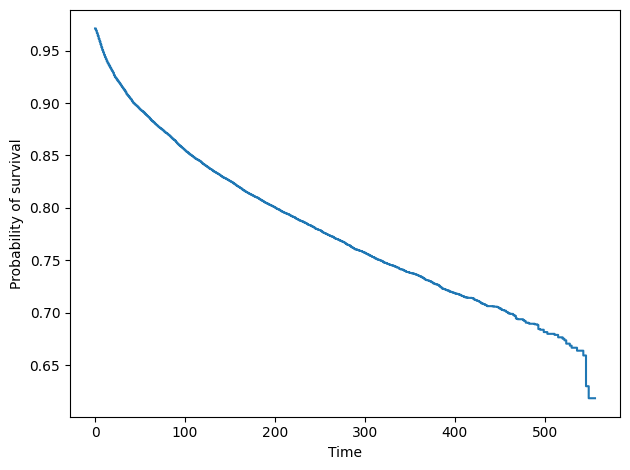

In [15]:
fig, ax = plt.subplots()
ax.step(time, survival_prob, where='post')
ax.set_ylabel('Probability of survival')
ax.set_xlabel('Time')

plt.tight_layout()

In [16]:
def agg_univariate(x):
    '''
    Função para calcular a quantidade de pets únicos em um agrupamento usando groupby.
    Para usar a função basta chamar com o método "apply"
    Ex:
        df.groupby('var').apply(agg_univariate)
        
    Input:
        x: dataframe contendo o id de pets como índice e demais variáveis que serão usadas na agregação
    '''
    names = {
        'pets': x.index.nunique()
    }

    return pd.Series(names, index=['pets'
                                  ])

In [47]:
# plots

def plot_prob_180(dp, v, d, sp):
    '''
    Função para criar o gráfico com a probabilidade de sobrevivência em "d" dias para cada categoria da variável "v"
    Ela é usada dentro da função plot_dp, onde são geradas as probabilidade de sobrevivência por categoria analisada.
    
    Inputs:
        dp: dataframe contendo a contagem de pets e probabilidade de sobrevivência para cada categoria da variável de agregação
        v: Nome da variável usada na agregação dos pets
        d: Quantidade de dias usados no corte da curva de sobrevivência para obter a probabilidade de sobrevivência de cada categoria
        sp: survival_prob aos d dias (probabilidade média de sobrevivência da curva geral)
    
    Output:
        Gráfico com as categorias no eixo x, a probabilidade de sobrevivência no eixo y primário e a contagem de pets no eixo y secundário
    '''
    
    ax1 = sns.set_style(style=None, rc=None )

    fig, ax1 = plt.subplots(figsize=(12,6))

    sns.lineplot(data = dp[f'palive_{d}_dias'], marker='o', sort = False, ax=ax1)
    plt.axhline(y = sp, color = 'r', label = f'Sobrevivência Média em {d} dias', ls='--')
    plt.legend(loc='best')
    
    ax2 = ax1.twinx()

    if dp.index.dtype=='boolean':
        x = ['Sim' if x==True else 'Não' for x in dp.index.values]
    else:
        x = dp.index
    
    sns.barplot(data = dp, x=x ,y='pets', alpha=0.5, ax=ax2)
    ax1.tick_params(axis='x', rotation=90)
#     ax1.set_ylim(bottom=0, top=1) # Habilite caso queira ver os gráficos com o eixo y principal das probabilidades sempre entre 0-1
    ax1.set_title(f'Probabilidade de sobrevivência em {d} dias por {v}')
    

In [48]:
def plot_dp(X, y, v, d, sp):
    '''
    Função para calcular a curva de sobrevivência por categoria da variável "v" especificada e plotar
    os gráficos com as curvas de sobrevivência por categoria, ao longo do tempo e o gráfico com a
    probabilidade de sobrevivência no tempo "d" em dias.
    
    Inputs:
        X: Dataframe com as potenciais variáveis explicativas para a sobrevivência de um pet
        y: Dataframe com o tempo de sobrevivência em dias (data de desligamento ou data atual) e
            a flag que indica True se o pet tiver sido desligado ou False caso ainda esteja ativo
        v: Nome da variável que será analisada
        d: Tempo em dias para realizar o corte na curva e plotar a probabilidade de sobrevivência até este dia
        sp: survival_prob aos d dias (probabilidade média de sobrevivência da curva geral)
        
    Outputs:
        Gráfico com as curvas de sobrevivência por categoria da variável testada
        Resultado do teste Chi Quadrado para avaliar se as categorias possuem efeito discriminatório. A hipótese nula é que todas as curvas são iguais.
        Gráfico com a distribuição de pets e probabilidade de sobrevivência no tempo "d" por categoria da variável "v"
    '''

    dp = X.groupby(v).apply(agg_univariate)
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    if pd.unique(X[v]).dtype=='boolean':
        cat = pd.unique(X[v])
    else:
        cat = pd.unique(X[v]).sort_values()
    # calculando a curva por categoria da variável
    for m in cat:
        mask_treatment = X[v] == m
        
        time, survival_prob = kaplan_meier_estimator(
            y['fl_churn'][mask_treatment],
            y['survival_in_days'][mask_treatment]
        )
        
        cd = list(time).index(max([x for x in time if x<=d]))
        
        dp.loc[dp.index==m, f'palive_{d}_dias'] = round(survival_prob[cd],2)
        
        if pd.unique(X[v]).dtype==bool:
            if m:
                l='Sim'
            else:
                l='Não'
        else:
            l=m
        ax.step(time, survival_prob, where='post', label=f'{l}')
    plt.axvline(x = d, color = 'r', label = f'Corte em {d} dias', ls='--')
    if len(pd.unique(X[v]))>10:
        plt.legend('',frameon=False)
    else:
        plt.legend(loc='best')
    ax.set_ylabel('Probability of survival')
    ax.set_xlabel('Time')
    ax.set_title(f'Curva de sobrevivência por {v}')
    
    plt.show()
    
    # calculando p-valor sobre a discriminação categorias da variável para as curvas de sobrevivência
    group_indicator = X.loc[:, v]
    groups = group_indicator.unique()
    
    dt=np.dtype('bool,int')
    yy=np.array(list(y[['fl_churn','survival_in_days']].itertuples(index=False, name=None)),dtype=dt)
    
    chi2, pvalue= compare_survival(yy, group_indicator)
    
    if pvalue<=0.1:
        print(f'A variável {v} discriminou de forma significante as curvas de sobrevivência, com pvalor de {round(pvalue,4)}')
    else:
        print(f'A variável {v} Não discriminou de forma significante as curvas de sobrevivência, com pvalor de {round(pvalue,4)}')
    
    # Plot prob sobrevivência em d dias
    plot_prob_180(dp, v, d, sp)
    
    return dp

# Curvas de sobrevivência para as categorias de cada variável

# Probabilidade de sobrevivência em 180 dias por variável/categoria

In [19]:
# Lista de variáveis que serão testadas
var_list = [
    'mix_procedimentos_alf',
    'idade_pet',
    'plano',
    'faixa_pets_simultaneos_ativos',
    'especie',
    'ultimo_evento',
    'status_microchip',
    'setup', 
    'vacina', 
    'add', 
    'ecom', 
    'clinico',
    'fl_cross_ecom', 
    'fl_cross_dh', 
    'fl_clube', 
    'faixa_frequencia_compra_ecom',
    'email_dominio'
]

### Descrição das variáveis testadas:
- mix_procedimentos_alf: São as jornadas distintas que cada pet já passou, iniciando em inclusão/contratação, depois setup (assinatura de contrato e microchipagem), compra de adicionais, vacinas, consultas clinicas e compra no ecom
- idade_pet: Filhote, Adulto ou Senior
- plano: Plano contratado
- faixa_pets_simultaneos_ativos: Quantidade de "irmãos" que o pet teve com plano ativo durante mesmo período
- especie: Cachorro ou Gato
- ultimo_evento: Último evento da Jornada
- status_microchip: Sem microchip, provisório, externo ou permanente
- setup: Pet já está microchipado
- vacina: Pet já fez vacina
- adicional: Pet já comprou adicionais
- ecom: Pet já realizou compra no ecom
- clinico: Pet já passou por atendimento clínico
- fl_cross_ecom: indica se o cliente veio do ecom ou conheceu depois do plano
- fl_cross_dh: indica se o cliente interagiu com doghero antes ou depois do plano
- fl_clube: indica se o cliente comprou o clube antes ou depois do plano
- faixa_frequencia_compra_ecom: frequencia de compra do cliente no ecom (caso seja cliente)
- email_dominio: dominio do email registrado no plano de saúde

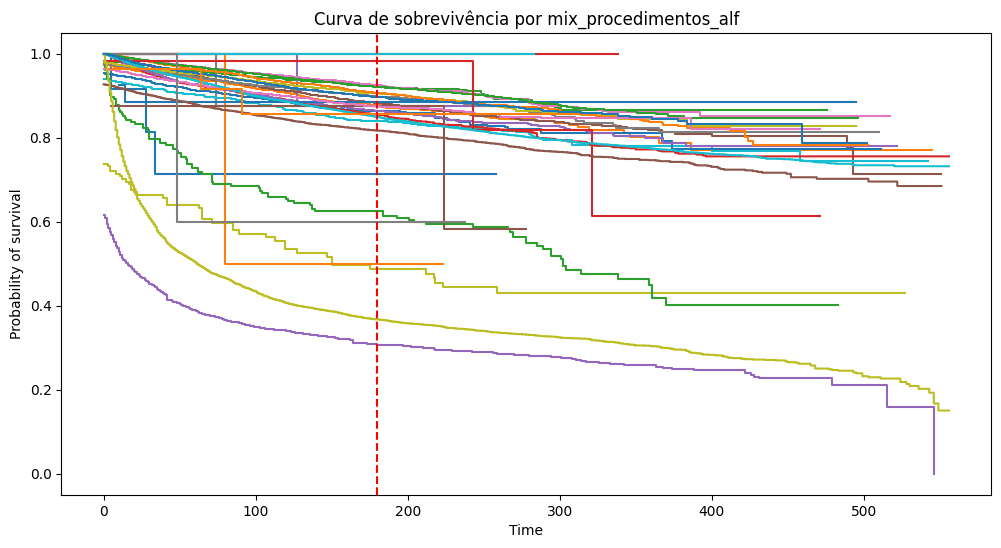

A variável mix_procedimentos_alf discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


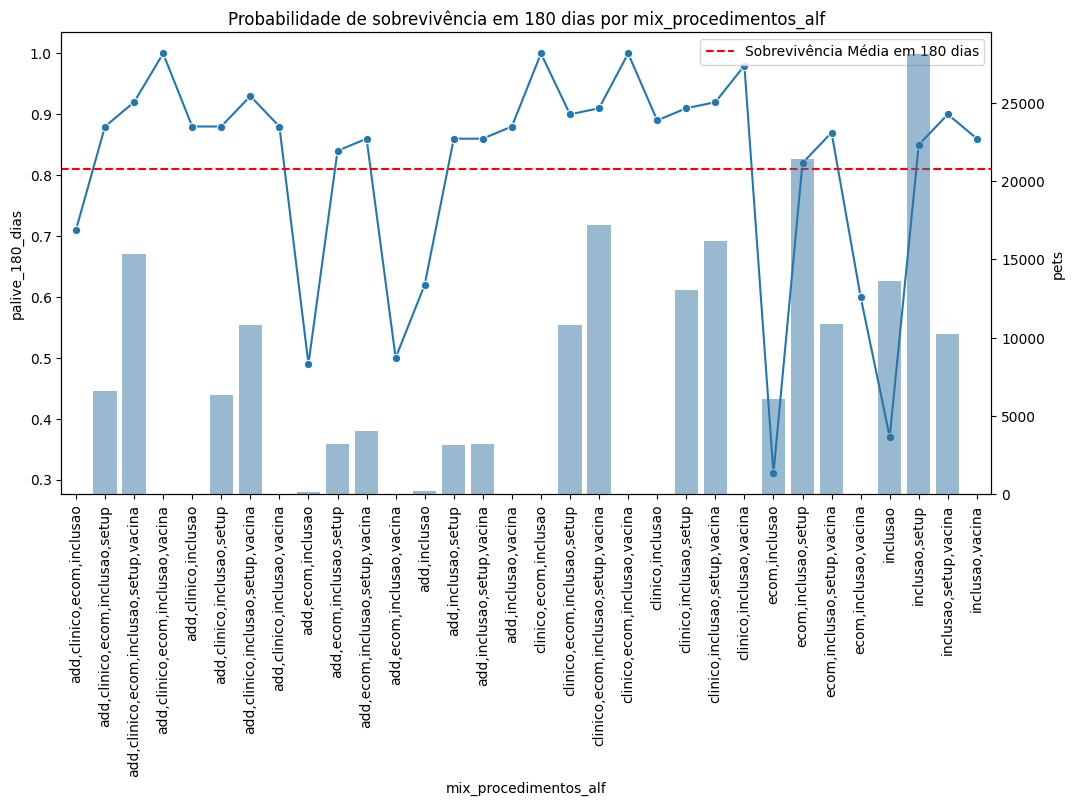

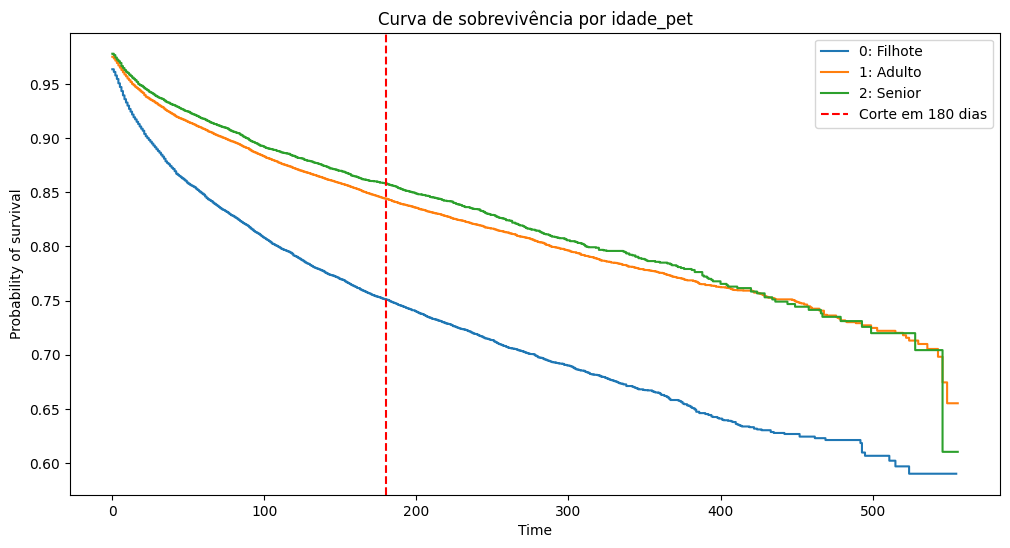

A variável idade_pet discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


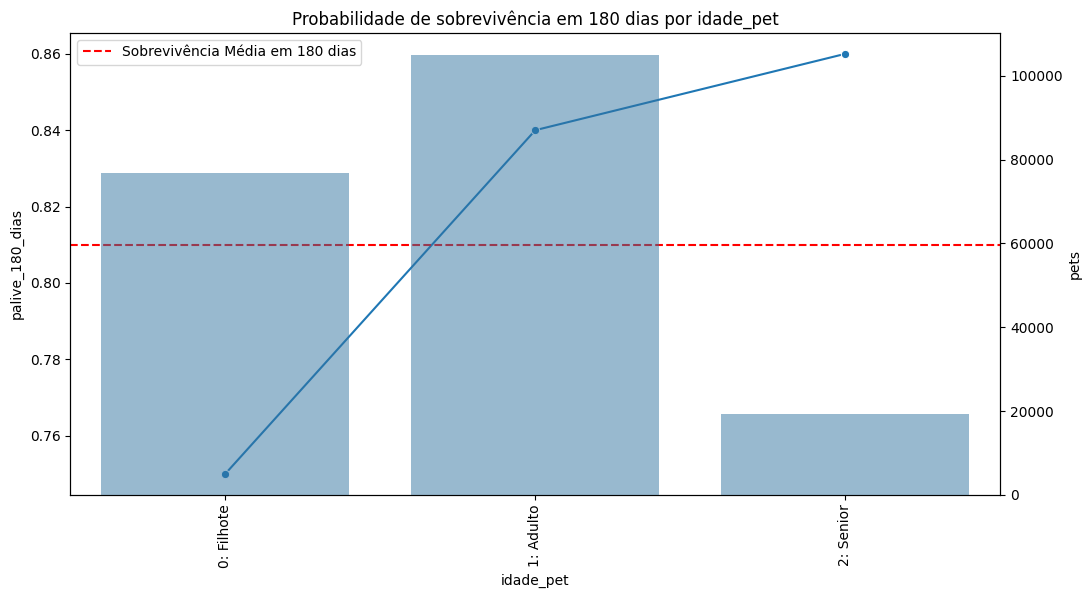

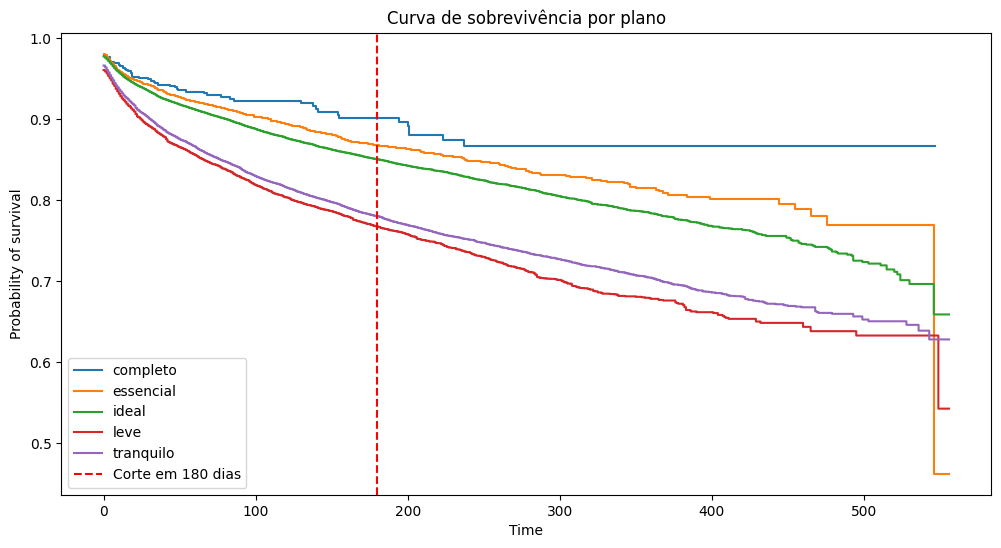

A variável plano discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


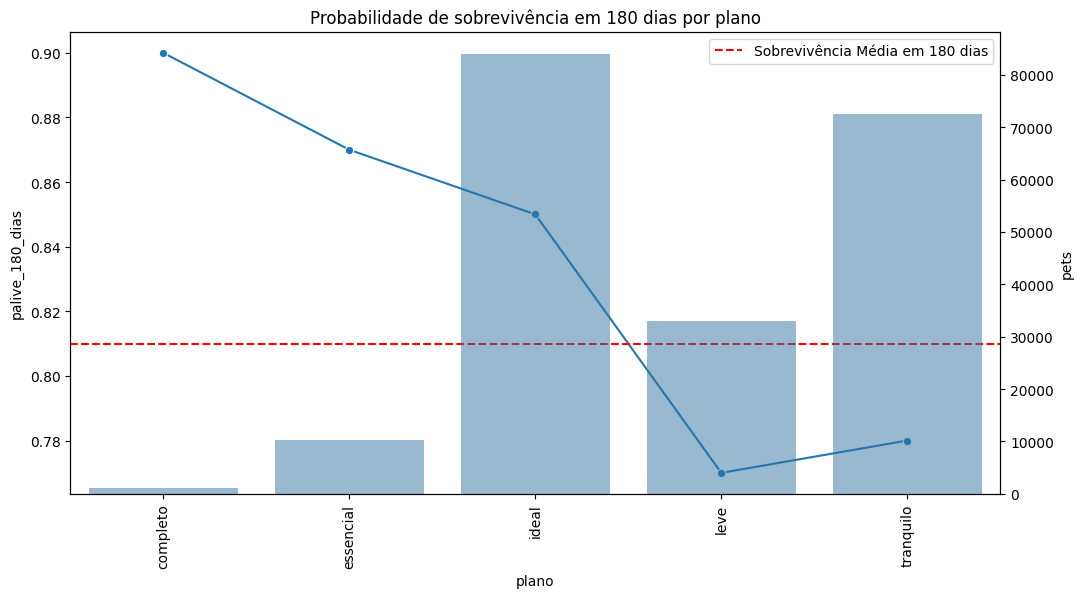

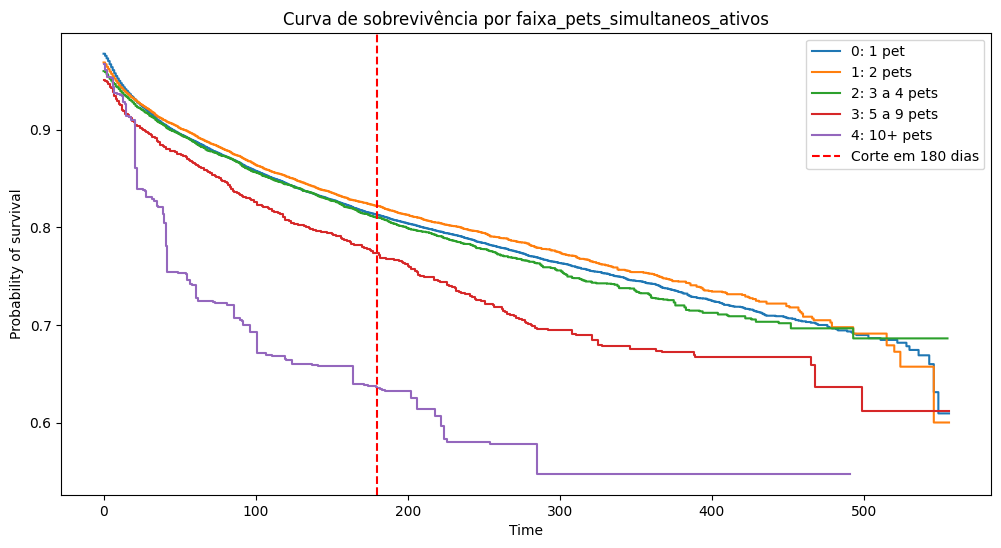

A variável faixa_pets_simultaneos_ativos discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


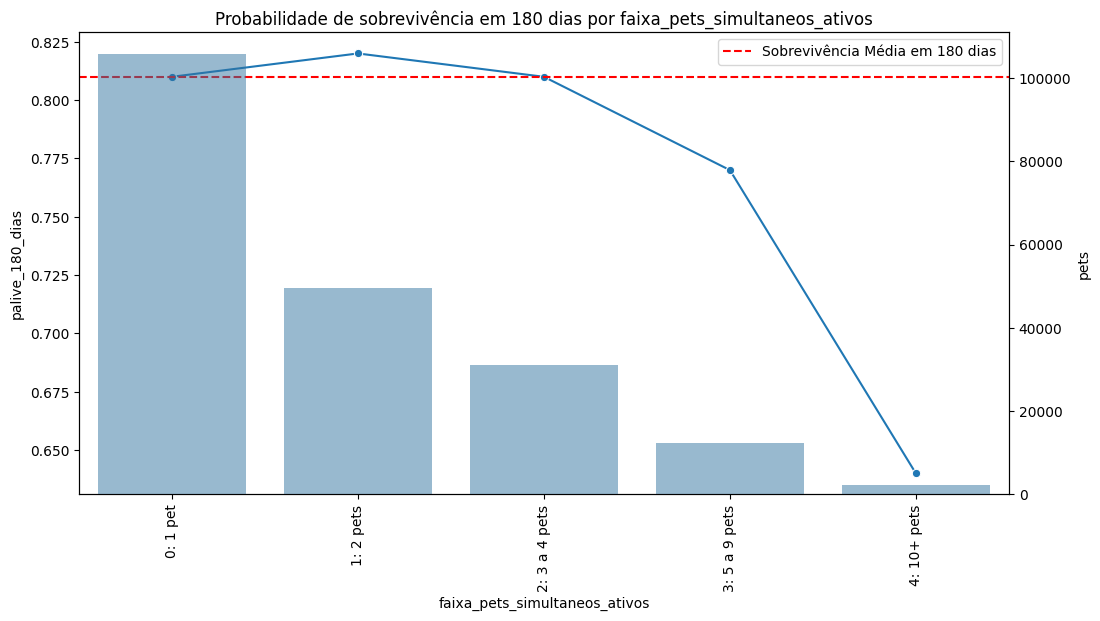

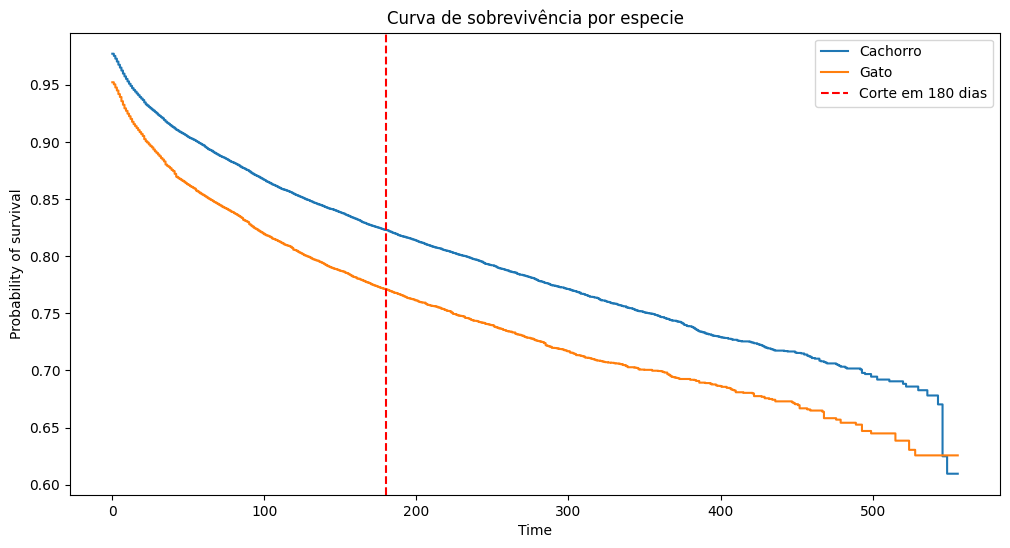

A variável especie discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


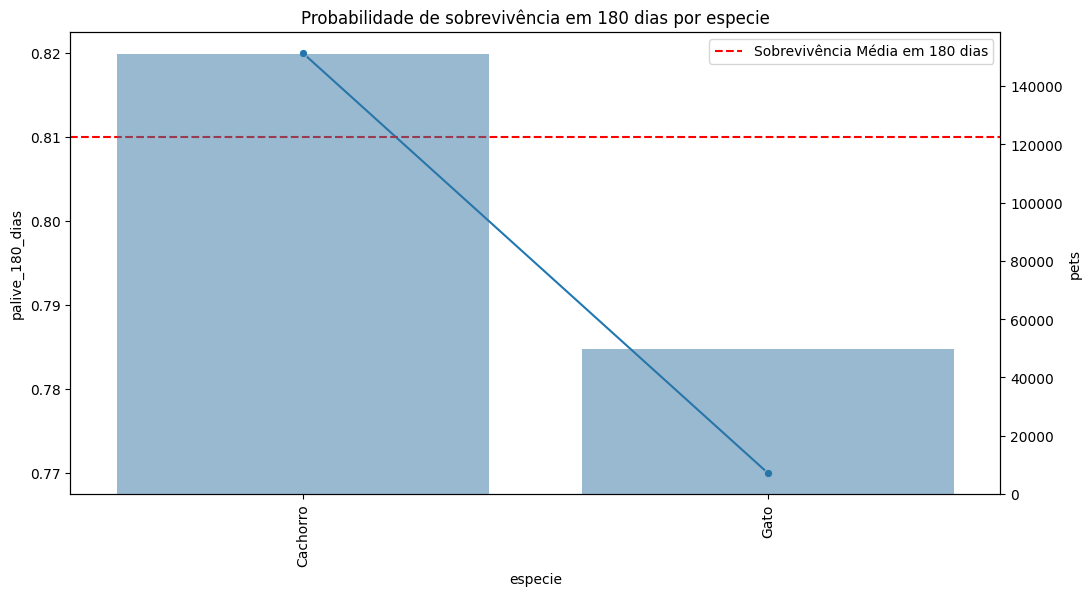

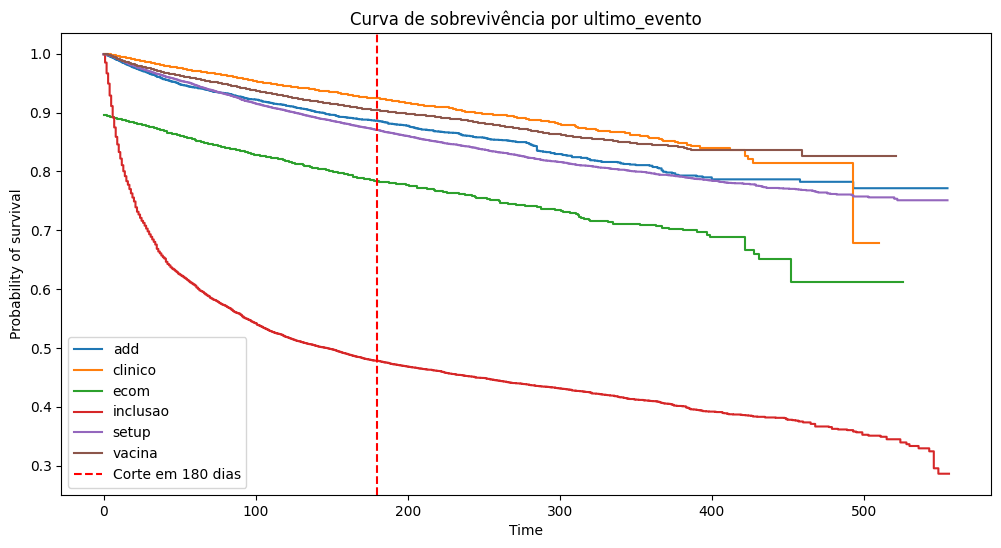

A variável ultimo_evento discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


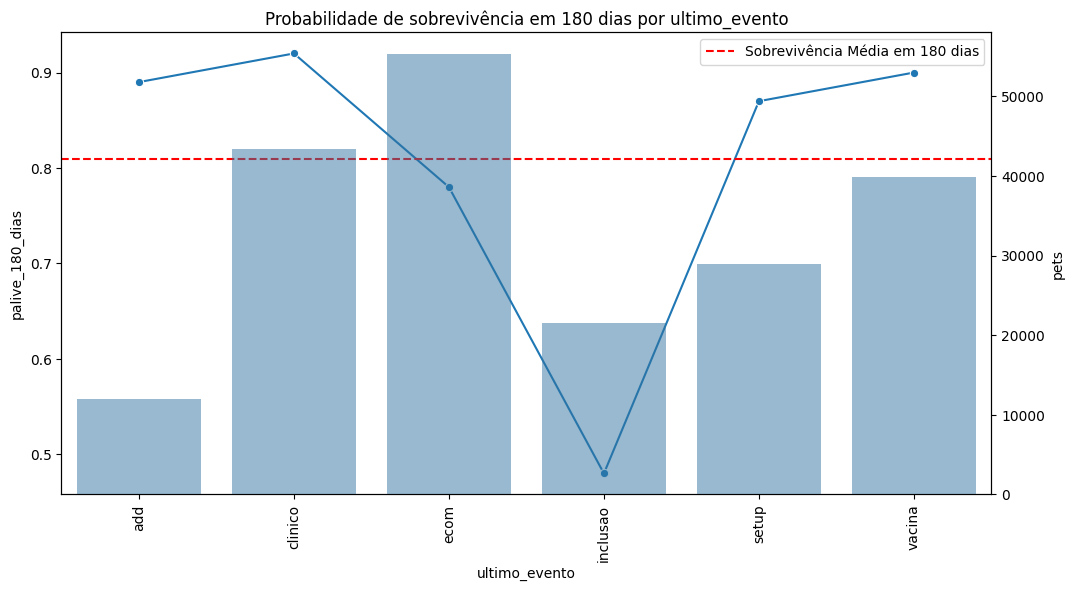

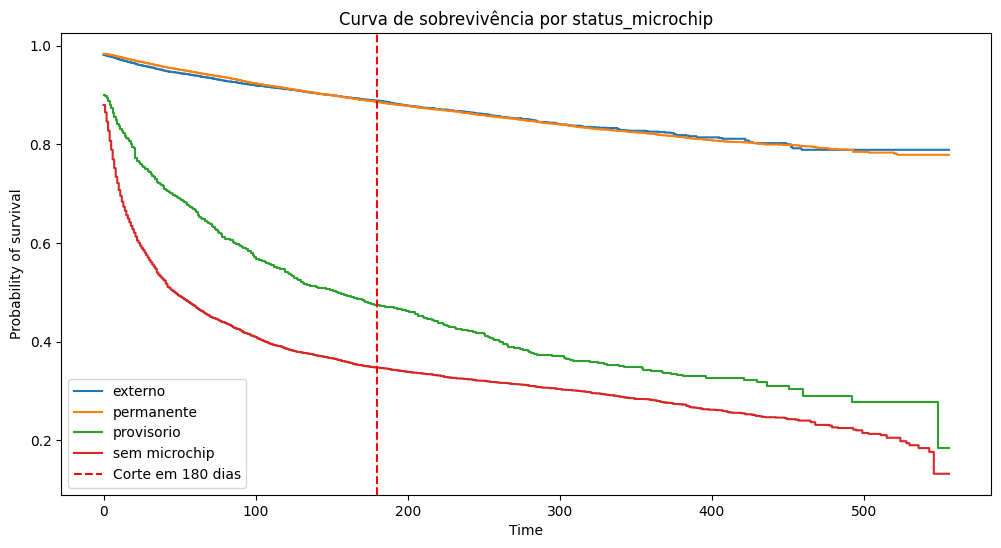

A variável status_microchip discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


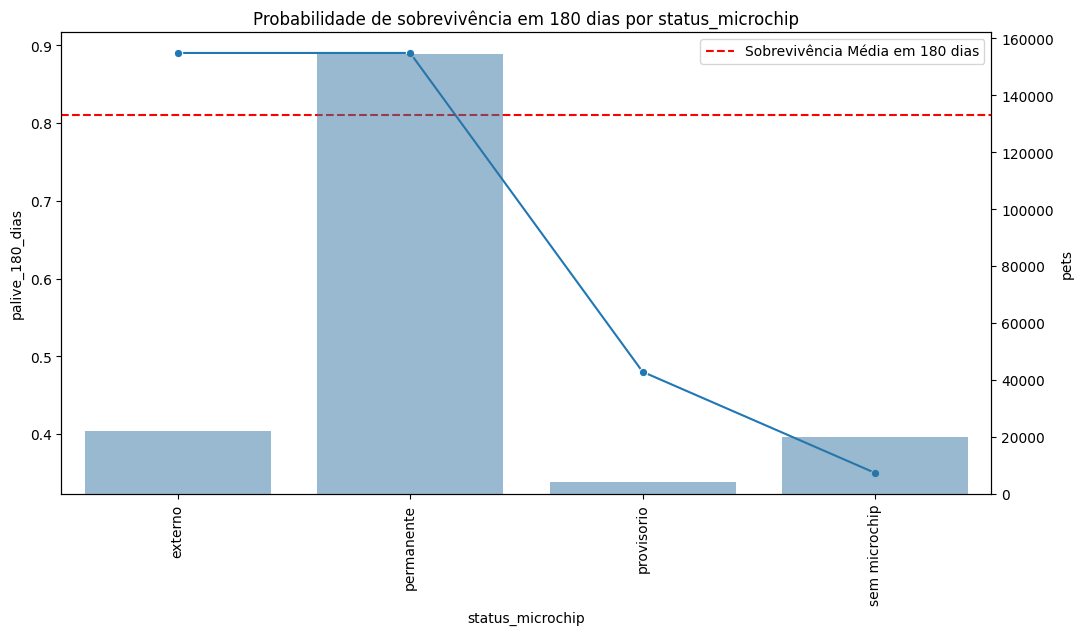

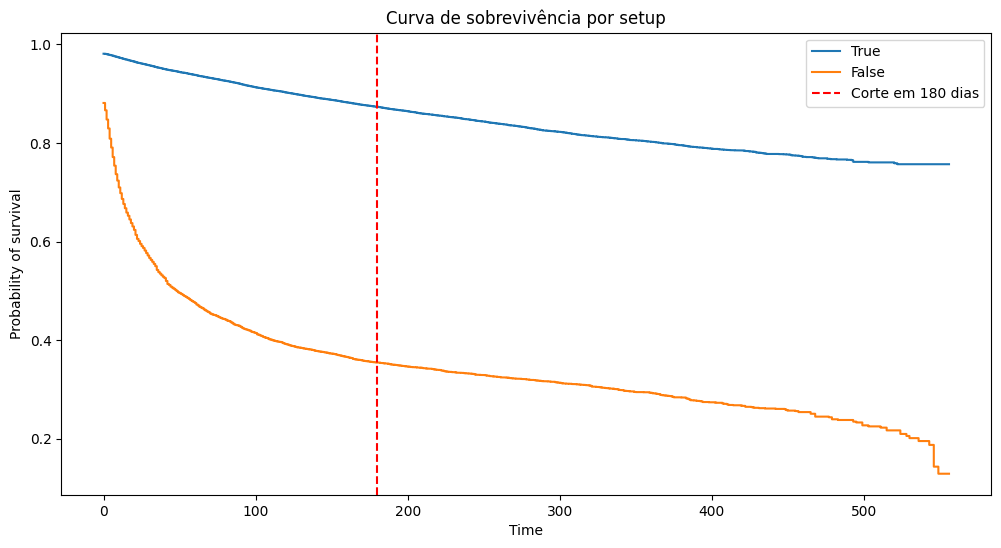

A variável setup discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


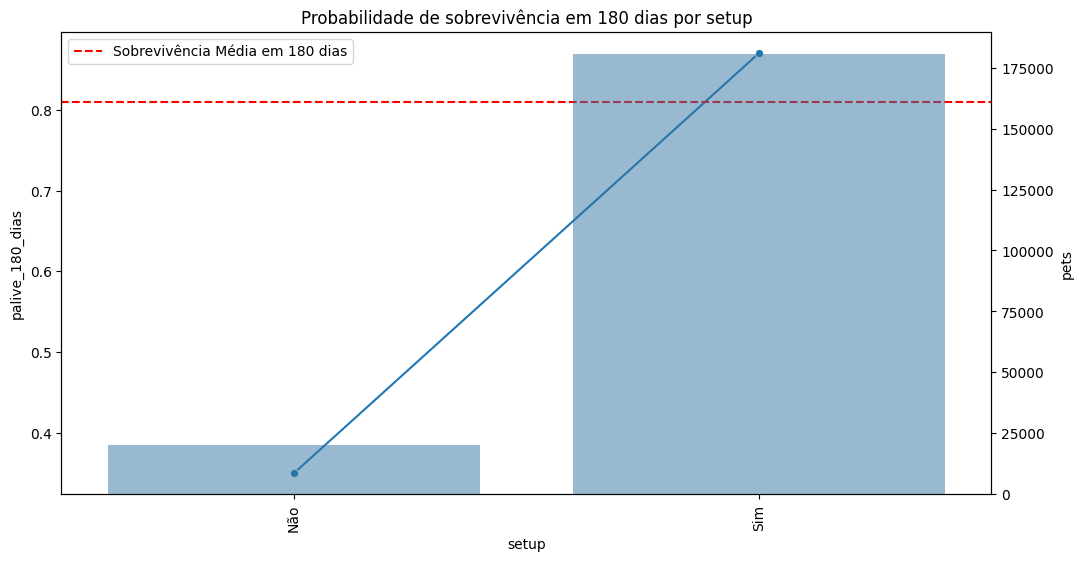

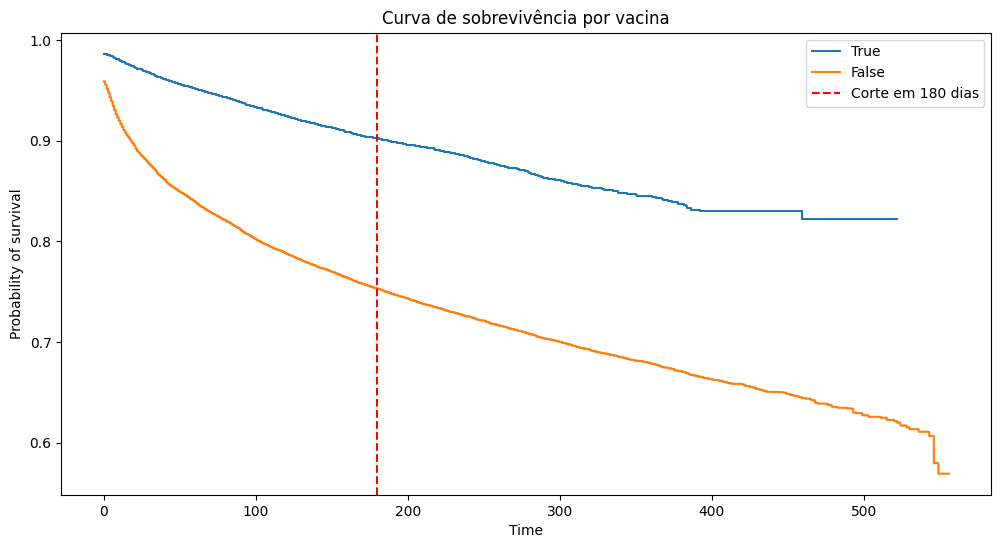

A variável vacina discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


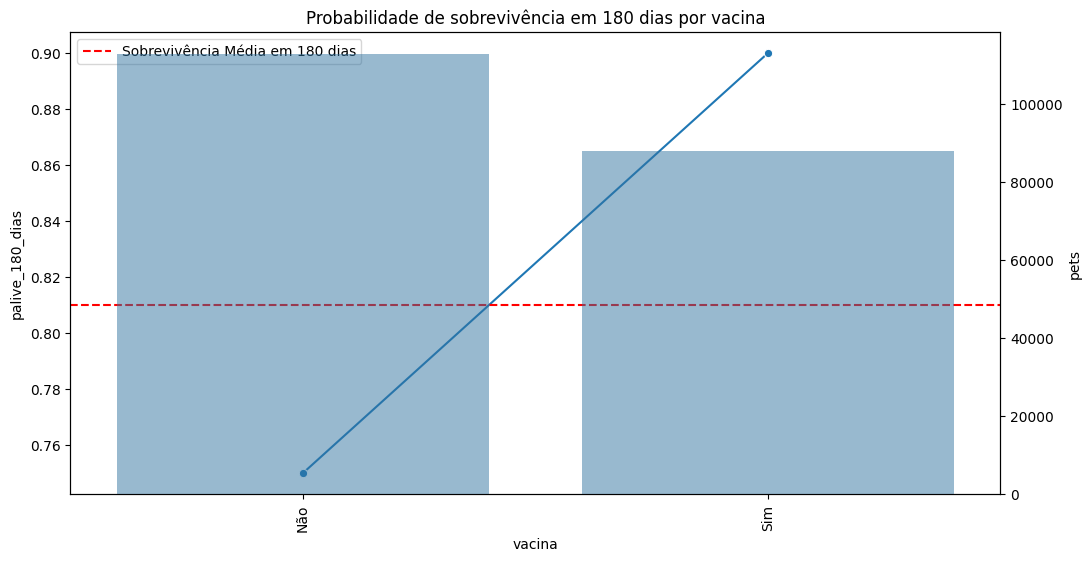

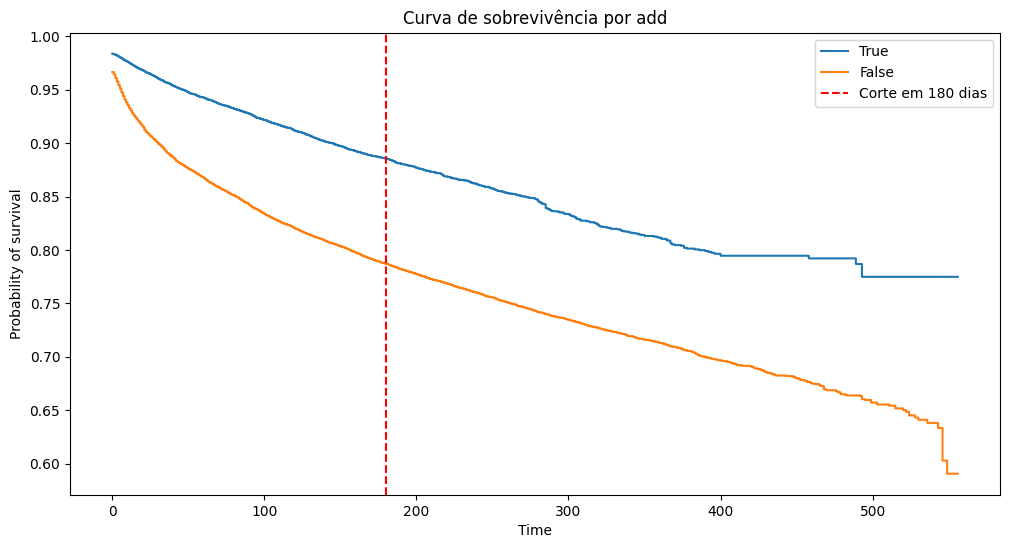

A variável add discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


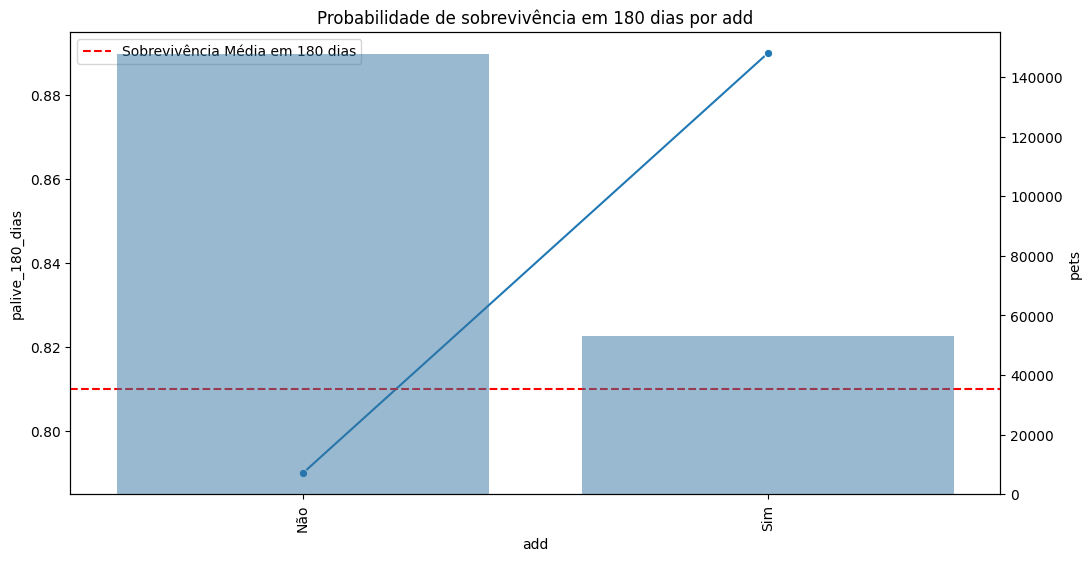

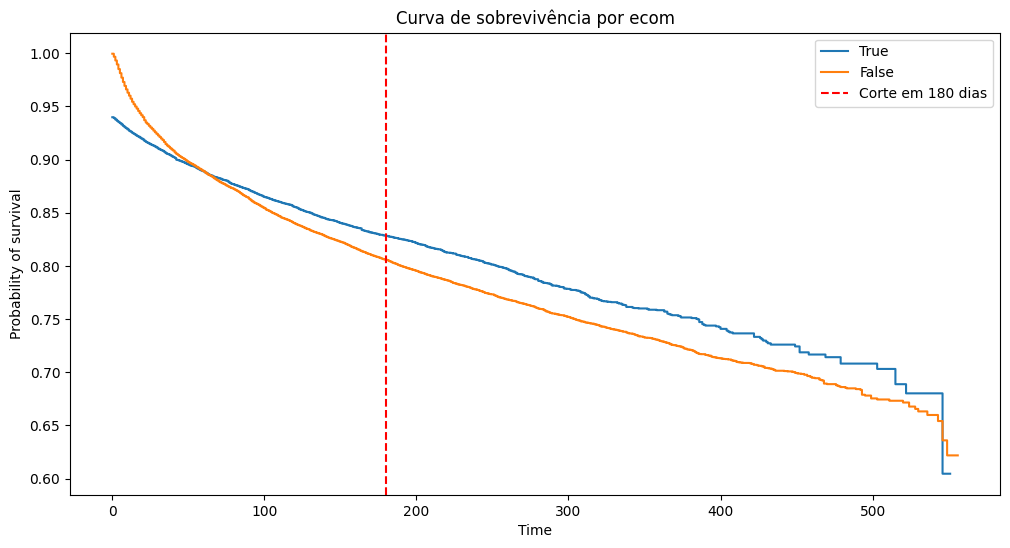

A variável ecom Não discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.4453


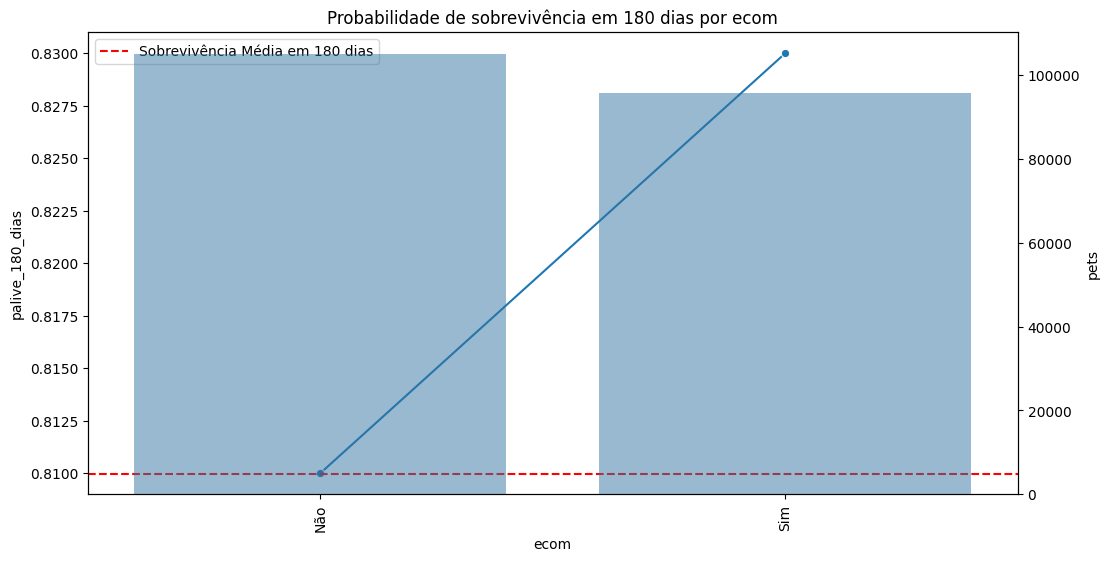

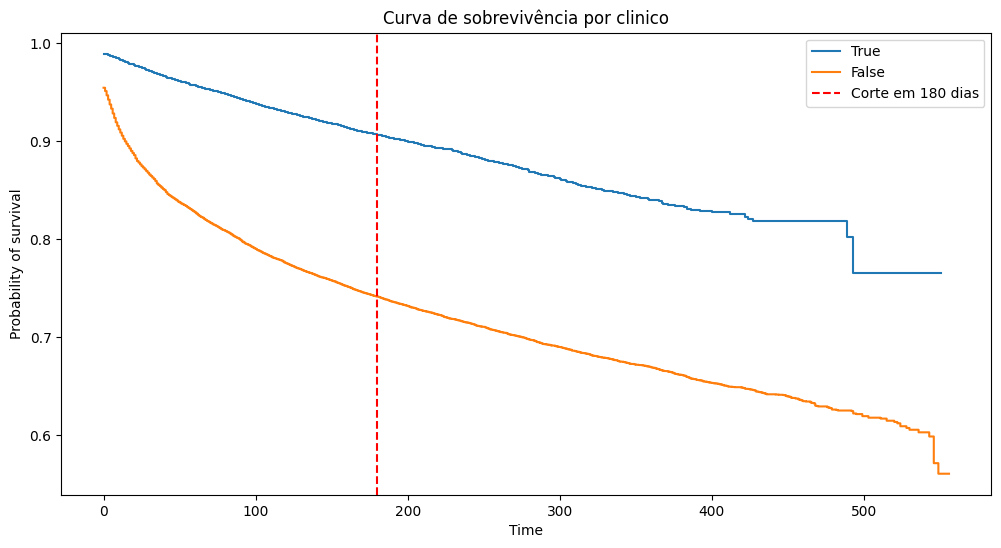

A variável clinico discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


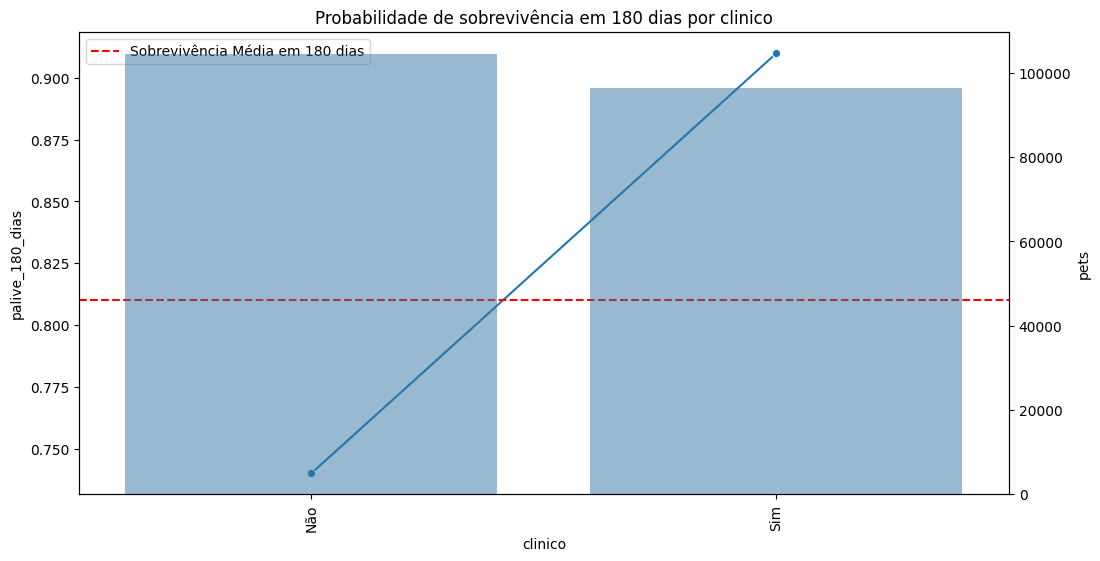

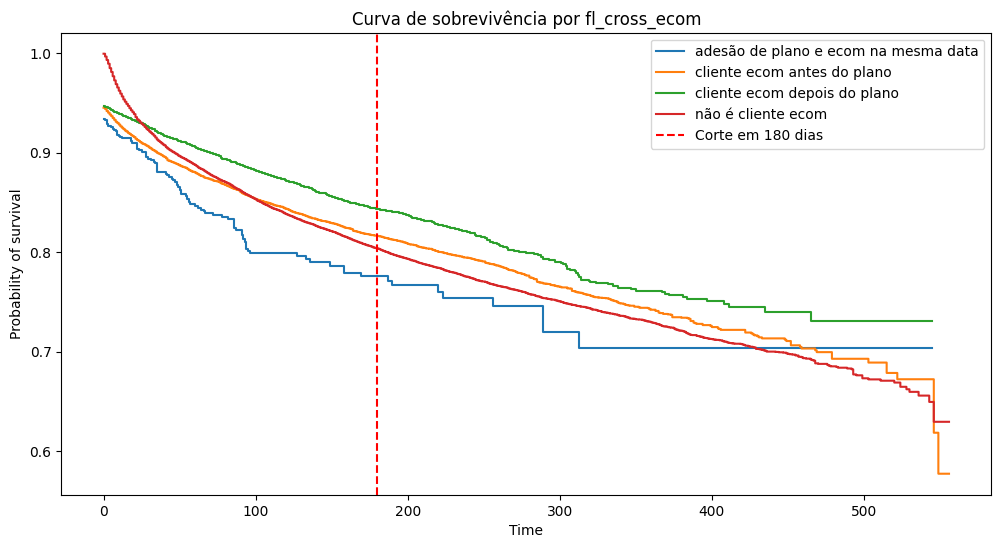

A variável fl_cross_ecom discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


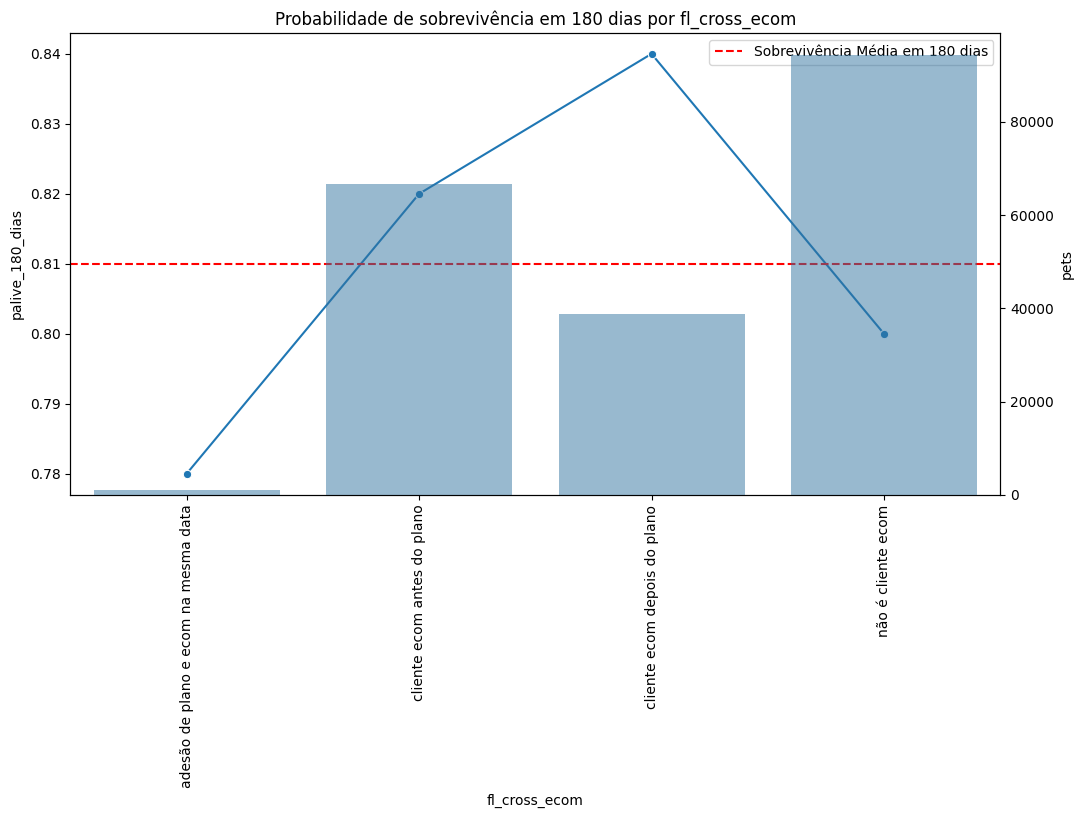

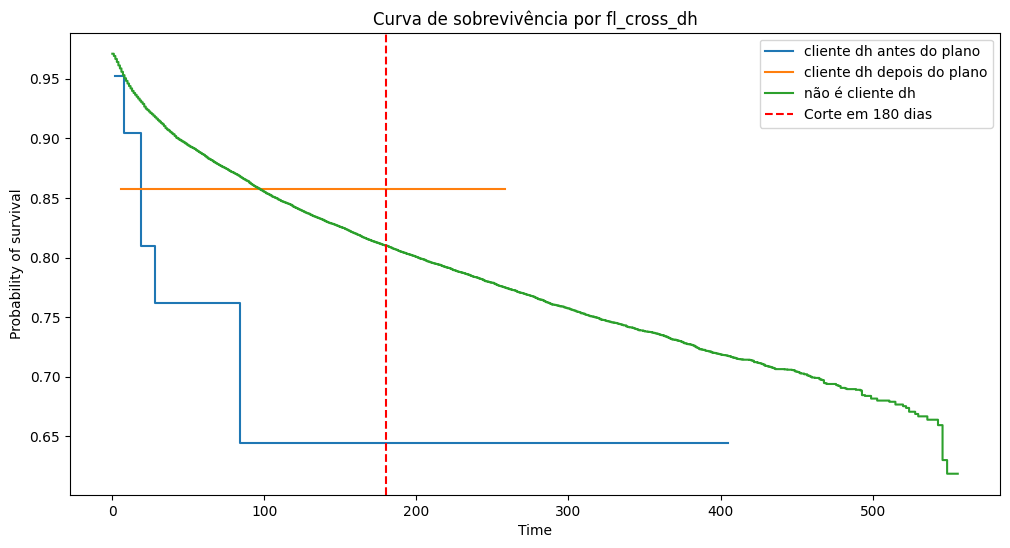

A variável fl_cross_dh Não discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.2948


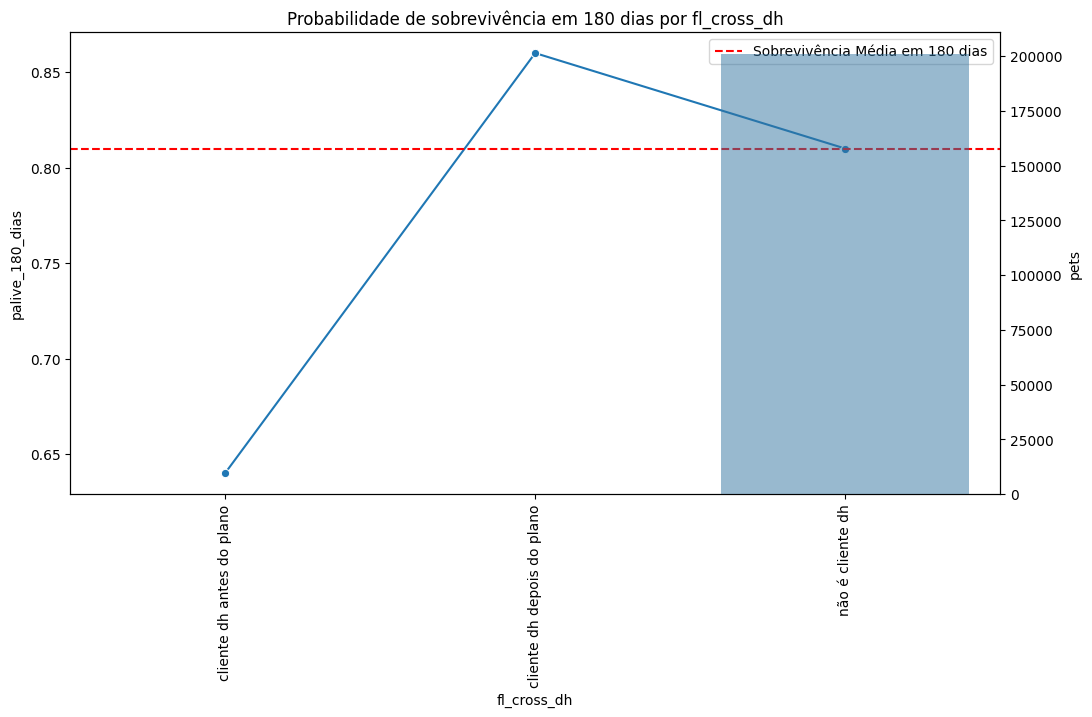

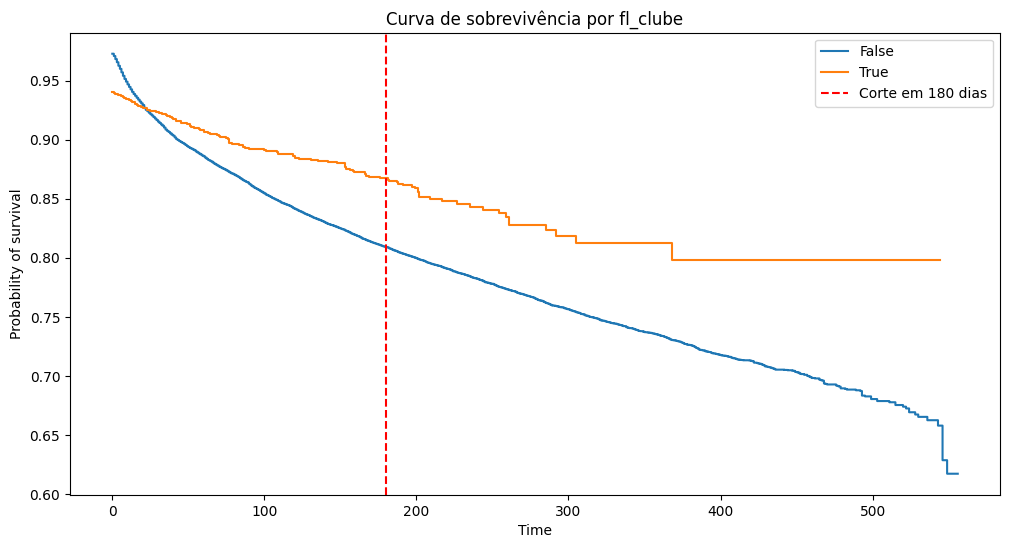

A variável fl_clube discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0327


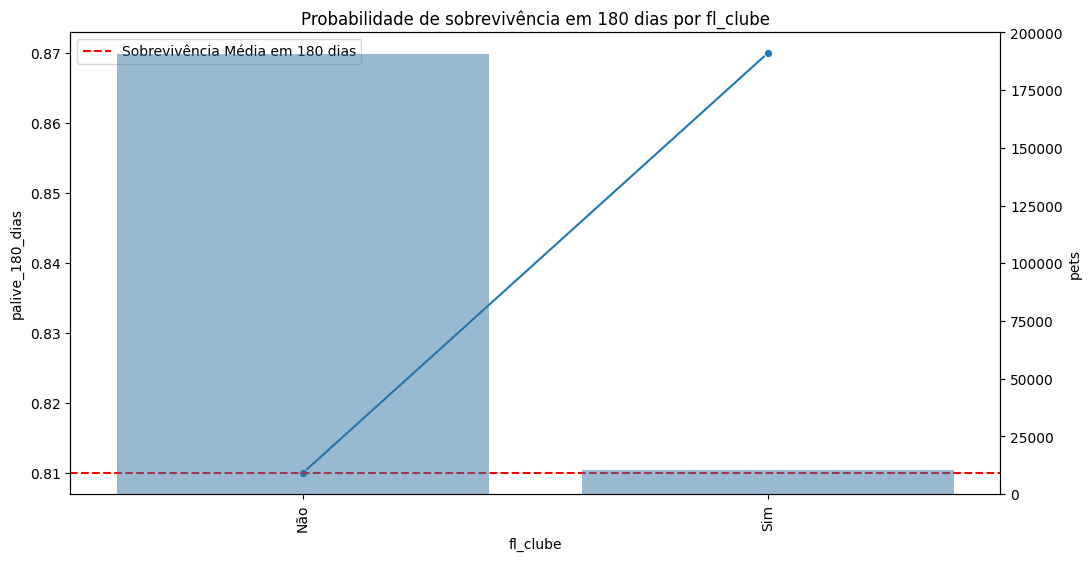

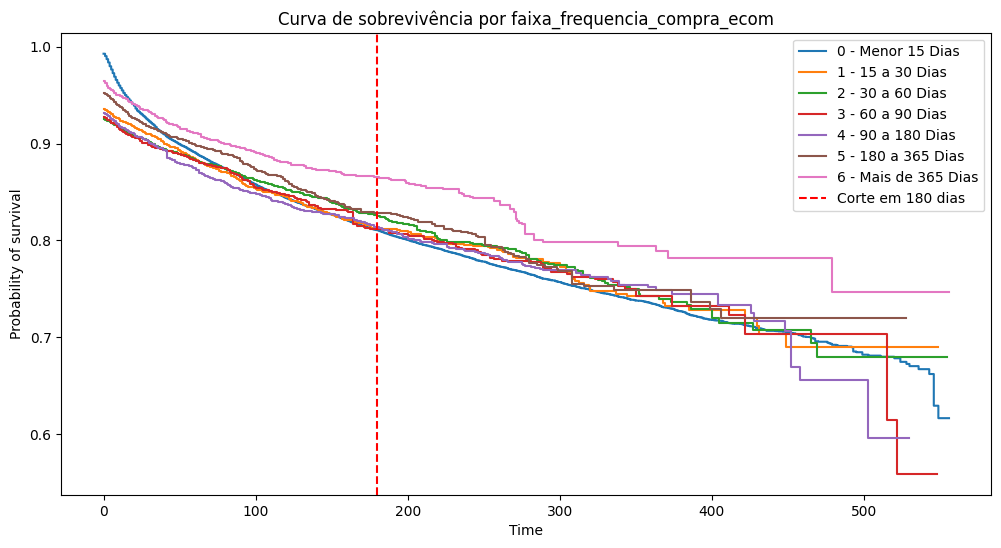

A variável faixa_frequencia_compra_ecom discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


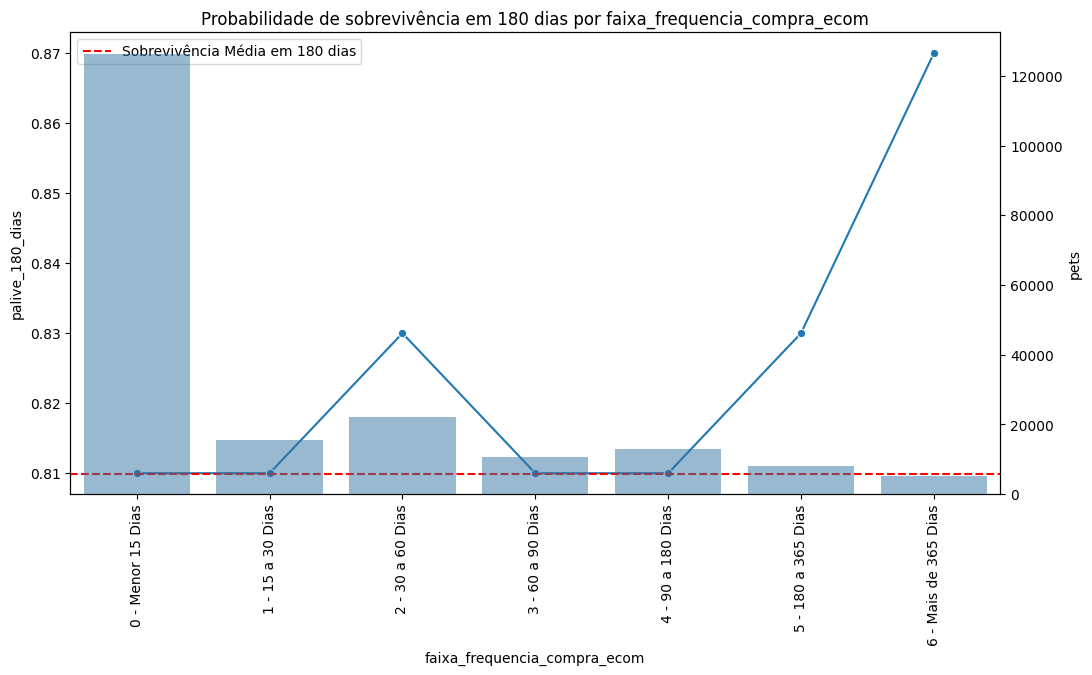

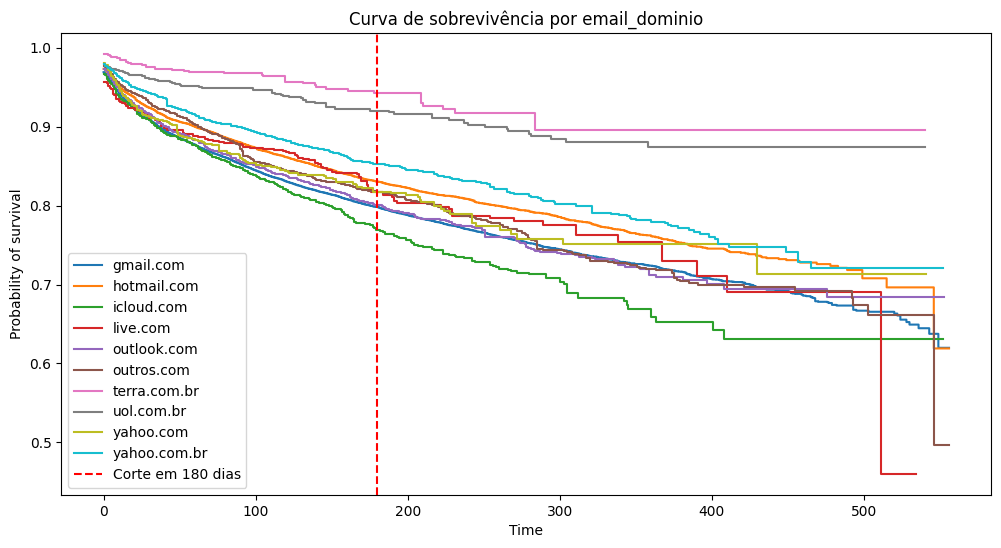

A variável email_dominio discriminou de forma significante as curvas de sobrevivência, com pvalor de 0.0


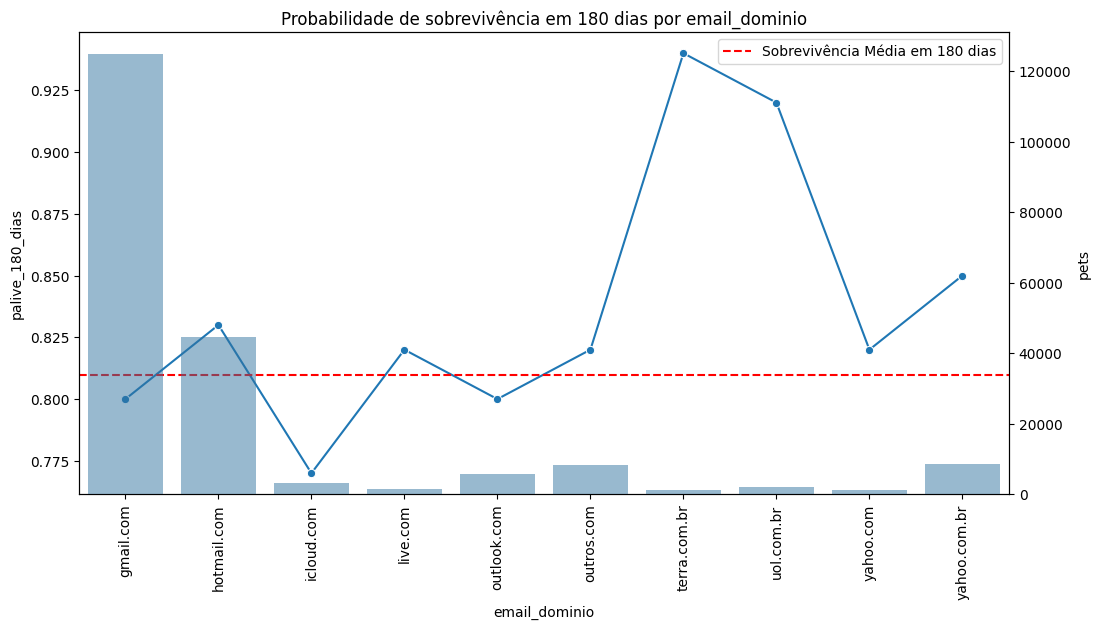

In [49]:
# Aqui estamos iterando sobre a lista de variáveis e aplicando as funções para calculo das curvas 
# e plotagem dos gráficos

for vl in var_list:
    plot_dp(X, y, vl, 180, survival_prob[180])

# Modelo Linear Multivariado utilizando Cox Potential Hazard Analysis

https://scikit-survival.readthedocs.io/en/stable/index.html

https://towardsdatascience.com/the-complete-introduction-to-survival-analysis-in-python-7523e17737e6

https://towardsdatascience.com/survival-analysis-part-a-70213df21c2e

In [21]:
# Lista das variáveis que serão usadas no modelo

var = [
        'idade_pet',
        'plano',
        'faixa_pets_simultaneos_ativos',
        'especie',
        'ultimo_evento',
        'status_microchip',
        'setup', 
        'vacina', 
        'add', 
        'ecom', 
        'clinico',
        'fl_cross_ecom', 
        'fl_cross_dh', 
        'fl_clube', 
        'faixa_frequencia_compra_ecom',
        'email_dominio'
]

# Criando o dataframe com encoding de variáveis categoricas (transformando tudo em booleanas)
X_num = OneHotEncoder().fit_transform(X[var])

In [22]:
# Separando o dataframe em base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_num, yy, test_size=0.2, stratify=y['fl_churn'], random_state=42)

In [23]:
# Ajustando o modelo ao dataset de treino

def run_cox_sa(xtn, xts, ytn, yts, plot=False):
    '''
    Função para rodar o modelo de Cox Potential Hazard Survival Analysis, printar o índice de AUC global
    AUC = Area under the curve
    Também plota o gráfico com o AUC ao longo do tempo, para mostrar como as variáveis mantém seu poder de discriminação
    ao longo do tempo
    
    Inputs:
        xtn: Variáveis explicativas do dataframe de treino
        xts: Variáveis explicativas do dataframe de teste
        ytn: Variáveis resposta do dataframe de treino
        yts: Variáveis resposta do dataframe de teste
        plot: Se quiser mostrar os gráficos trocar para True. default=False
        
    Outputs:
        AUC Global do modelo
        Gráfico com o AUC por janela de tempo
        Retorna o modelo treinado como variável
    '''    
    cph = CoxPHSurvivalAnalysis()
    cph.fit(xtn, ytn)
    cindex = cph.score(xts, yts)
    print(f'AUC Global do modelo: {round(cindex, 3)}')

    # Plot the time-depdendent ROC and calculate AUC
    
    time_interval = np.arange(7, 365, 7)

    cph_risk_scores = cph.predict(xts)
    
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(ytn, yts, cph_risk_scores, time_interval)
    
    if plot:
        
        fig, ax = plt.subplots()

        ax.plot(time_interval, cph_auc, marker='o')
        ax.axhline(cph_mean_auc, ls='--')
        ax.set_xlabel('Days after enrollment')
        ax.set_ylabel('Time-dependent AUC')

        plt.grid(True)
        plt.tight_layout()
        
        plt.show()
    
    return cph

AUC Global do modelo: 0.799


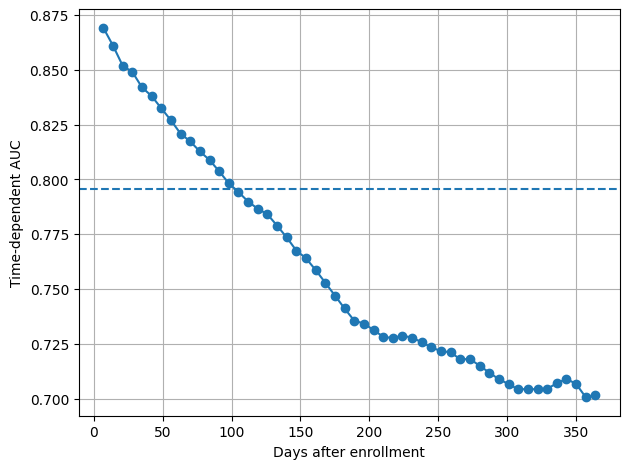

In [24]:
cph = run_cox_sa(X_train, X_test, y_train, y_test, plot=True)

In [25]:
def prob_survival(df, X_num, cph, i):
    '''
    Função para aplicar a predição de sobrevivência sobre um dataset
    
    Inputs:
        df: dataframe com os dados por pet
        X_num: Dataframe com as variáveis utilizadas no modelo, já como encodings
        cph: Modelo treinado usando CoxPHSurvivalAnalysis
        i: Identificação do pet a ser predito (no caso o índice do dataframe)
    Output:
        Probabilidade de sobrevivência do pet na data atual ou na data em que ele foi desligado
    '''
    
    ci = cph.predict_survival_function(X_num.loc[X_num.index==i])

    try:
        p = round(ci[0].y[df.loc[df.index==i], 'survival_in_days']*100,1)

    except:
        p = min(ci[0].y)

    return p

In [26]:
# loop em todos os pets da base para calcular a probabilida de sobrevivência na data atual ou de desligamento
for i in tqdm(df.index):
    df.loc[df.index==i, 'prob_churn'] = prob_survival(df, X_num, cph, i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200911/200911 [15:02<00:00, 222.51it/s]


### Probabilidade média de Sobrevivência e tempo médio de sobrevivência para pets Desligados (True) e Ativos (False)

In [27]:
def agg_mean(x):
    '''
    Função para calcular as médias de indicadores em um agrupamento usando groupby.
    Para usar a função basta chamar com o método "apply"
    Ex:
        df.groupby('var').apply(agg_mean)
        
    Input:
        x: dataframe contendo o id de pets como índice e demais variáveis que serão usadas na agregação
    '''
    names = {
        'mean_prob_churn': round(x['prob_churn'].mean(),1),
        'mean_survival_in_days': round(x['survival_in_days'].mean(),1)
    }

    return pd.Series(names, index=['mean_prob_churn',
                                   'mean_survival_in_days'
                                  ])
df.groupby(['fl_churn']).apply(agg_mean)

,mean_prob_churn,mean_survival_in_days
fl_churn,,
False,0.8,136.2
True,0.4,64.2


### Proporção de Pets Ativos/Inativos por score de probabilida de sobrevivência obtido no modelo

<Axes: xlabel='prob_churn', ylabel='Count'>

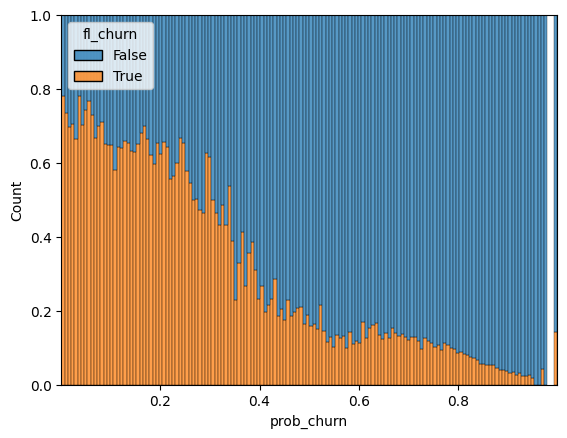

In [28]:
sns.histplot(data=df, x='prob_churn', hue='fl_churn', multiple='fill')

### Contagem de Pets Ativos/Inativos por score de probabilida de sobrevivência obtido no modelo

<Axes: xlabel='prob_churn', ylabel='Count'>

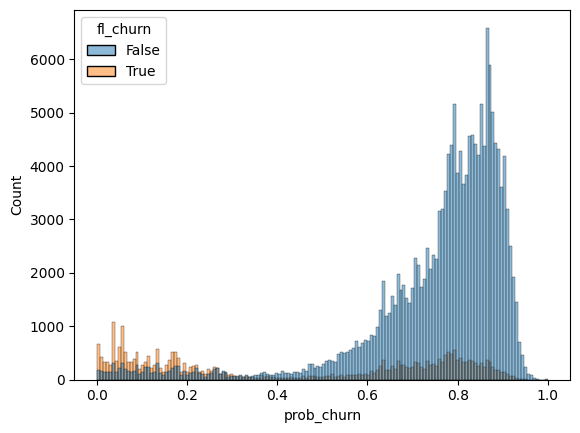

In [29]:
sns.histplot(data=df, x='prob_churn', hue='fl_churn', multiple='layer')

In [30]:
col = 'prob_churn'

conditions = [
    (df[col]<= .1),
    (df[col]>.1) & (df[col]<=.2),
    (df[col]>.2) & (df[col]<=.3),
    (df[col]>.3) & (df[col]<=.4),
    (df[col]>.4) & (df[col]<=.5),
    (df[col]>.5) & (df[col]<=.6),
    (df[col]>.6) & (df[col]<=.7),
    (df[col]>.7) & (df[col]<=.8),
    (df[col]>.8) & (df[col]<=.9),
    (df[col]>.9)
]

choices = [
    '0 - 0 a 10%',
    '1 - 10 a 20%',
    '2 - 20 a 30%',
    '3 - 30 a 40%',
    '4 - 40 a 50%',
    '5 - 50 a 60%',
    '6 - 60 a 70%',
    '7 - 70 a 80%',
    '8 - 80 a 90%',
    '9 - 90 a 100%',
]

df['prob_churn_range'] = np.select(conditions, choices, np.nan)

In [31]:
#Usando a mesma função de contagem de pets por categoria

df_dist_c = df.groupby(['prob_churn_range', 'fl_churn']).apply(agg_univariate).reset_index()
df_dist_c = df_dist_c.pivot_table(index='prob_churn_range', columns='fl_churn', values='pets').reset_index()

df_dist_c['Ativo'] = df_dist_c[False]/df_dist_c[False].sum()
df_dist_c['Churn'] = df_dist_c[True]/df_dist_c[True].sum()

### Distribuição de Pets Ativos/Inativos por faixa de probabilida de sobrevivência obtido no modelo

<Axes: xlabel='prob_churn_range'>

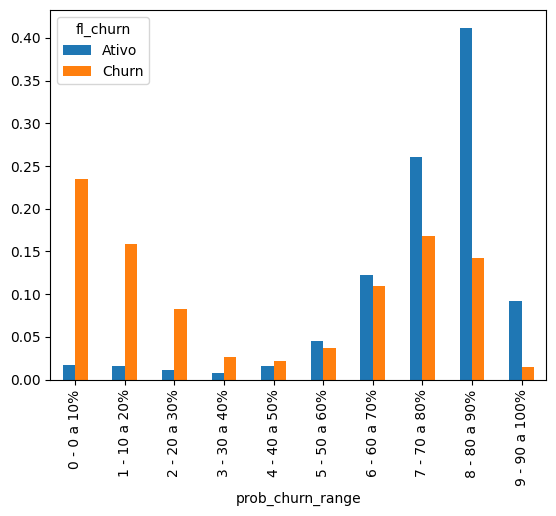

In [32]:
df_dist_c.plot(x='prob_churn_range', y=['Ativo', 'Churn'], kind='bar')

### Matriz de Confusão
#### Predito (Probabilidade>0,5 = Ativo) vs. Real
- True = Churn
- False = Ativo

In [64]:
print(classification_report(df.fl_churn, np.where(df['prob_churn']>= .8, False, True)))
accuracy = accuracy_score(df.fl_churn, np.where(df['prob_churn']>= .8, False, True))
print('Accuracy = {:0.2f}%.'.format(accuracy))

              precision    recall  f1-score   support

       False       0.95      0.50      0.66    169559
        True       0.24      0.84      0.37     31352

    accuracy                           0.56    200911
   macro avg       0.59      0.67      0.51    200911
weighted avg       0.83      0.56      0.61    200911

Accuracy = 0.56%.


## Gradient Boosting

In [66]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [67]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement

In [50]:
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=0.05, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

In [ ]:
time_interval = np.arange(1, 180, 7)

gb_risk_scores = est_early_stopping.predict(X_test)
gb_auc, gb_mean_auc = cumulative_dynamic_auc(y_train, y_test, gb_risk_scores, time_interval)

fig, ax = plt.subplots()

ax.plot(time_interval, gb_auc, marker='o')
ax.axhline(gb_mean_auc, ls='--')
ax.set_xlabel('Days after enrollment')
ax.set_ylabel('Time-dependent AUC')

plt.grid(True)
plt.tight_layout()

# Modelo de sugestão de NBA

Para cada churner testar qual é a melhor recomendação?
Qual passo da jornada traz uma melhor prob de sobrevivência em 180 dias?
- Identificar os possíveis passos da jornada

    Se parou na inclusão:
    
        - se estiver dentro da carência (assumindo data contratação) - orientar a microchipagem e compra de antecipação
        - se estiver fora da carência - propor microchipagem para abater carência e ofertar vacina ou consulta
        
    Se já tiver o setup:
    
        - se estiver dentro da carência: compra de antecipação
        - se estiver fora da carência: vacina, consulta ou ecom (o que maximiza a probabilidade de sobrevivência futura)
        
    Se já tiver algum uso, sugerir um dos que faltam
    
    Se já tiver todos os usos, sugerir algum diferente do ultimo realizado

In [65]:
# filtrando os pets ativos com probabilida de sobrevivência abaixo de 0.5

churners = df.loc[(df['prob_churn']< .8) & (df.fl_churn==False)].copy()

In [52]:
# params

temvars = [
        'vacina', 
        'ecom', 
        'clinico']

depara = {
          'vacina':'ultimo_evento=vacina'
         ,'ecom':'ultimo_evento=ecom'
         ,'clinico':'ultimo_evento=clinico'
         }

ue = ['ultimo_evento=clinico', 'ultimo_evento=ecom', 'ultimo_evento=inclusao','ultimo_evento=setup', 'ultimo_evento=vacina']


In [53]:
def best_action(X, i, tv, ue, depara):
    '''
    Função para calcular a probabilidade de sobrevivência em d dias para cada ação possível de ser feita com um pet.
    O Algoritmo vai prever a curva de sobrevivência para cada ação sugerida e anotar a de maior probabilidade.
    
    Inputs:
        X: Dataframe com as variáveis explicativas encodadas
        i: identificação do pet (normalmente o índice)
        tv: variáveis booleanas que indicam se o pet já experimentou certa etapa da jornada de uso do plano
        ue: listagem de últimos eventos possíveis, com a nomenclatura da variável encodada
        depara: Dicionário com o de-para de nomes das variáveis booleanas de experimentação com a listagem de últimos eventos encodados
    Outputs:
        Nome da recomendação de ação que maximiza a probabilidade de sobrevivência do pet
    '''
    Xbest = X.loc[X.index==i].copy()
    
    max_pred=0

    for c in Xbest[tv].columns:
        
        ex = Xbest.copy()
        
        ex[c] = np.add(Xbest[c],True)
        
        ex[ue]=0
        
        ex[depara[c]] = 1
    
        pred = cph.predict_survival_function(ex)[0].y[180]
        
        if pred > max_pred:
            max_pred=pred
            reco = depara[c]

    return reco


In [54]:
def nba(df, X, tv, ue, depara):
    '''
    Função para sugerir o next best action aplicando as regras de negócio e recomendações usando a função best_action
    
    Inputs:
        df: dataframe contendo como índice os pets que receberão uma recomendação de ação para retenção
        X: Dataframe com as variáveis explicativas encodadas e os pets como índice
        i: identificação do pet (normalmente o índice)
        tv: variáveis booleanas que indicam se o pet já experimentou certa etapa da jornada de uso do plano
        ue: listagem de últimos eventos possíveis, com a nomenclatura da variável encodada
        depara: Dicionário com o de-para de nomes das variáveis booleanas de experimentação com a listagem de últimos eventos encodados
    
    Outputs:
        Dataframe com a marcação de next best action
    '''
    for i in tqdm(df.index):

        if df.loc[df.index==i, 'setup'].bool()==False:
            if df.loc[df.index==i, 'add'].bool()==False: # placeholder para validar se o pet já passou período de carência minima
                df.loc[df.index==i, 'reco'] = f'Realizar a microchipagem para começar a contar carência'
            else:
                df.loc[df.index==i, 'reco'] = f'Realizar a microchipagem para ficar apto a usar o plano'

        if (df.loc[df.index==i, 'setup'].bool()==True):
            if bool(random.getrandbits(1)):  # True é placeholder para validação de pet em periodo de carencia
                if df.loc[df.index==i, 'add'].bool()==False:
                    df.loc[df.index==i, 'reco'] =  f'Em período de carência, pode comprar antecipação'
                else:
                    df.loc[df.index==i, 'reco'] = best_action(X, i, tv, ue, depara)
            else:
                df.loc[df.index==i, 'reco'] = best_action(X, i, tv, ue, depara)
    return df

In [61]:
# test = churners[:1000]
# test = nba(test)
# test.groupby('reco').apply(agg_univariate)

In [66]:
churners = nba(churners, X_num, temvars, ue, depara)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84132/84132 [06:59<00:00, 200.49it/s]


### Contagem de pets agrupados para cada tipo de recomendação

In [67]:
churners.groupby('reco').apply(agg_univariate)

,pets
reco,
"Em período de carência, pode comprar antecipação",29154
Realizar a microchipagem para começar a contar carência,6504
Realizar a microchipagem para ficar apto a usar o plano,220
ultimo_evento=clinico,39963
ultimo_evento=vacina,8291


In [68]:
reco_by_evento = churners.groupby(['reco', 'ultimo_evento']).apply(agg_univariate).reset_index()
reco_by_evento.pivot_table(index='reco', columns='ultimo_evento', values='pets', aggfunc=sum, fill_value=0)

ultimo_evento,add,clinico,ecom,inclusao,setup,vacina
reco,,,,,,
"Em período de carência, pode comprar antecipação",0,1348,15001,1638,7708,3459
Realizar a microchipagem para começar a contar carência,0,4,1460,5017,0,23
Realizar a microchipagem para ficar apto a usar o plano,113,3,78,19,0,7
ultimo_evento=clinico,2292,13,21544,1666,8007,6441
ultimo_evento=vacina,769,1932,5461,45,84,0


### ultimo_evento=clinico seria recomendar uma consulta para quem está com risco de churn e ainda não realizou nenhuma consulta de checkup

# Exemplos individuais

In [62]:
def curva_individual(df, i, cph, X_num):
    '''
    Função para calcular a curva de sobrevivência de um pet, dadas as caracteristicas e variáveis usadas na modelagem do modelo de coxPHSurvivalAnalysis
    
    Input:
        df: dataframe com os pets como índice
        i: identificação do pet
        cph: modelo de CoxPHSurvivalAnalysis já treinado
        X_num: dataframe com as variáveis explicativas encodadas
    
    Output:
        Gráfico com a descrição do perfil do pet e respectiva curva de sobrevivência
    '''
    
    ci = cph.predict_survival_function(X_num.loc[X_num.index==i])
    
    time_points = np.arange(1, 365)

    nome = df.loc[df.index==i]['nome_pet'].values[0]

    label = f'Pet: {nome}'
    
    for n, surv_func in enumerate(ci):
        
        plt.step(time_points, surv_func(time_points), where='post', label=label)

    ttd = df.loc[df.index==i, 'survival_in_days'].values[0]

    especie = df.loc[df.index==i]['especie'].values[0]

    plano = df.loc[df.index==i]['plano'].values[0]
    
    faixa_idade = df.loc[df.index==i]['idade_pet'].values[0]
    
    faixa_pets_simultaneos_ativos = df.loc[df.index==i]['faixa_pets_simultaneos_ativos'].values[0]
    
    jornada = df.loc[df.index==i]['mix_procedimentos_data'].values[0]
    
    ultimo_evento = df.loc[df.index==i]['ultimo_evento'].values[0]
    
    prob = round(ci[0].y[ttd]*100,1)
    
    title = f'''
        {especie} {faixa_idade[3:]} com {faixa_pets_simultaneos_ativos[3:]} simulâneo(s).
        Possui o plano {plano}.
        Já passou por: {jornada}.
        Último evento foi {ultimo_evento} há {ttd} dias.
        '''
       
    plt.ylabel('Probabilidade de sobreviver')
    plt.xlabel('Tempo desde último evento')
    plt.axvline(x = ttd, color = 'r', label = f'Prob atual do pet: {prob}', ls='--')
    plt.legend(loc='best')
    plt.title(title, loc='left')
    plt.tight_layout()
    plt.show()

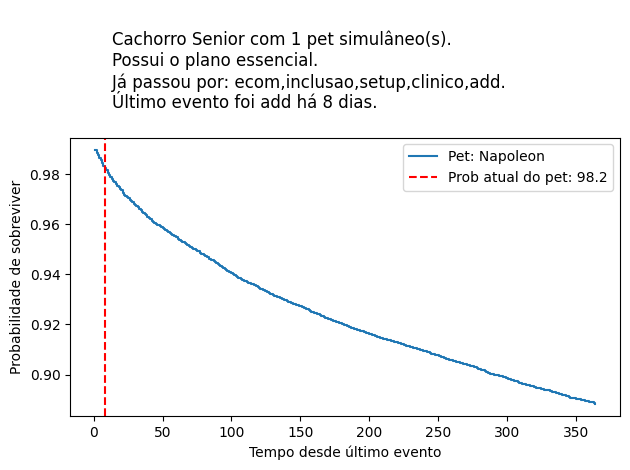

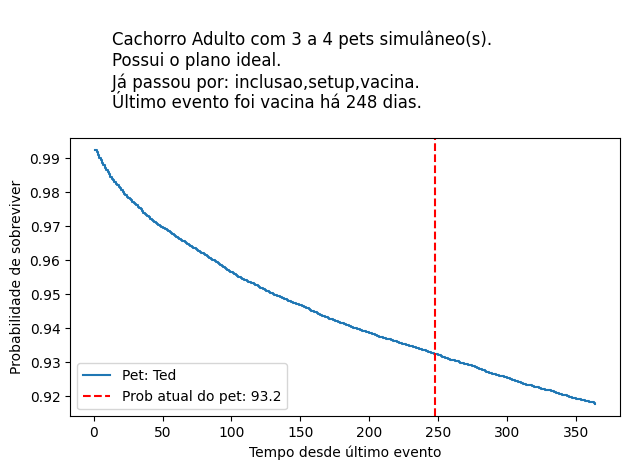

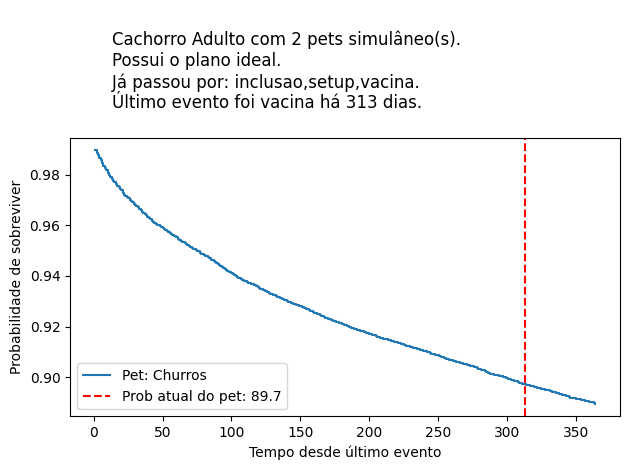

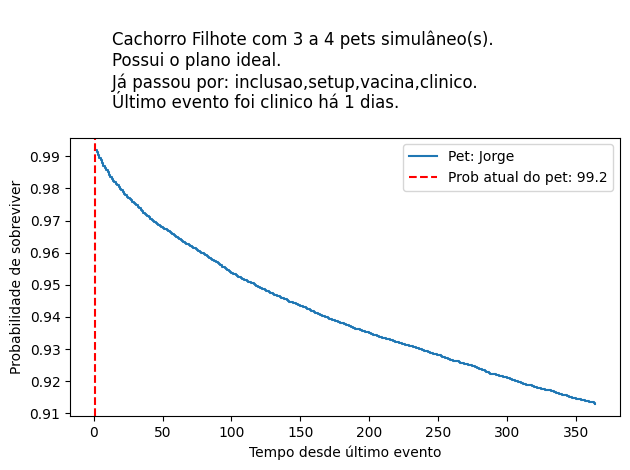

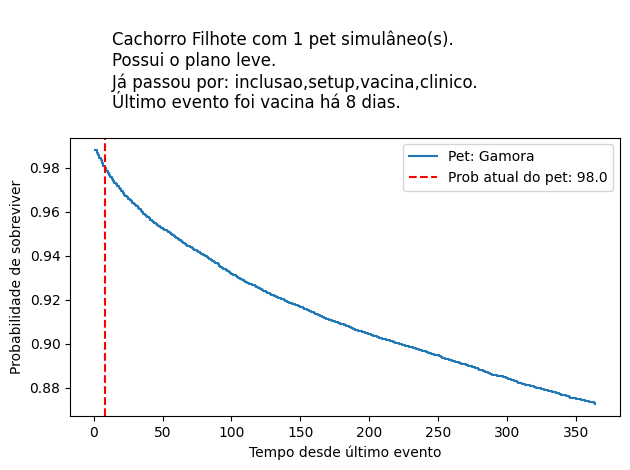

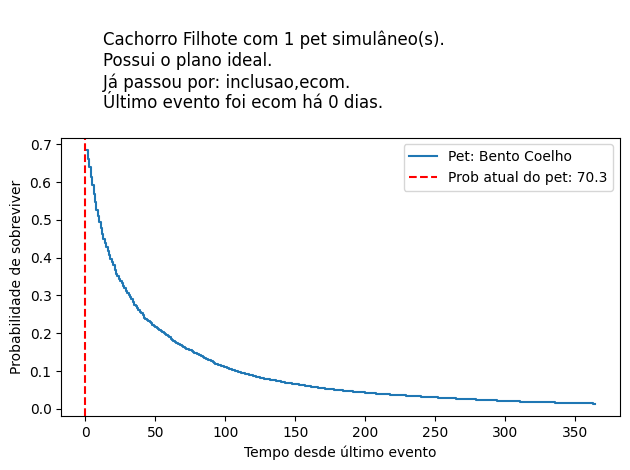

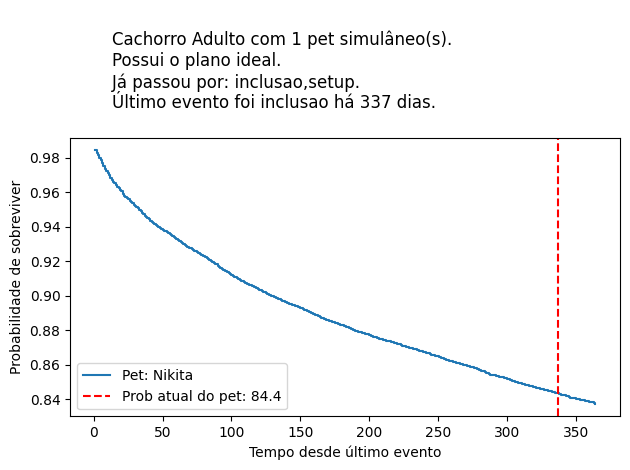

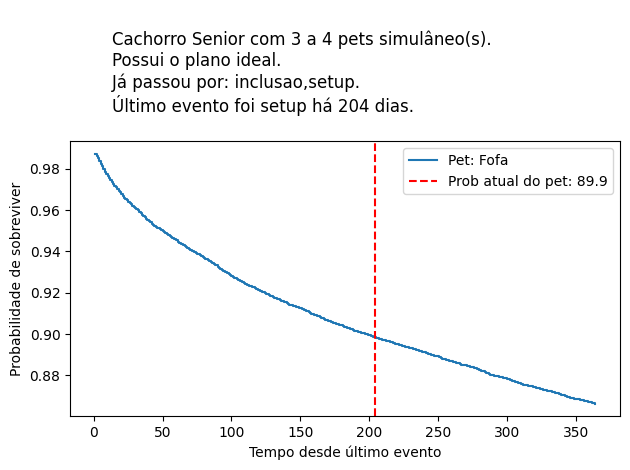

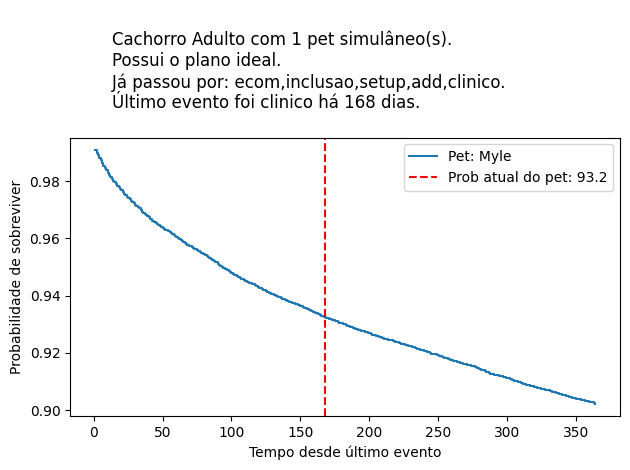

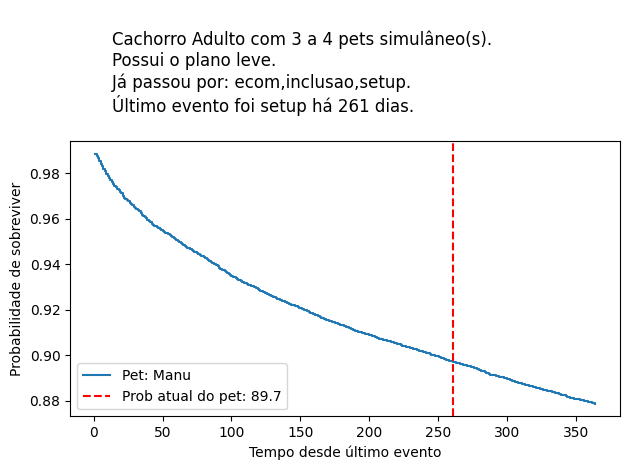

In [63]:
# Mostrando a curva individual de 10 pets aleatórios

for ex in range(10):
    curva_individual(df, random.choices(df.index)[0], cph, X_num)

### Próximos passos

~~- Validar como ficam as probabilidades da curva de sobrevivência de quem deu churn na tempo em que o churn ocorreu (quebrado pelas variáveis do modelo) - validar se a curva está fazendo sentido~~

~~- Distribuição das probabilidades vs. tempo~~
    
~~- Testar se os resultados ficam melhores usando o modelo agregado~~

Novas variáveis a serem testadas:

- perfil demográfico
- perfil de rede próxima
- perfil de consumo no ecom
- Contratação de bundle (clube)
- Presença de compra no ecom quebrar entre: antes/depois da contratação do plano

Alinhamentos:

- Mostrar para time de CRM os resultados preliminares e validar se o caminho faz sentido
    - Se fizer sentido, combinar as regras para recomendação da ação dado o cenário e perfil
    - Combinar como fariamos um teste disso via braze
    - Criar um acompanhamento do teste via dashboard